# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:16<00:00, 2102.16it/s]


In [23]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(160176, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 200K datapoints to work upon which got reduced to approx. 160K datapoints after all 
the text processing and data deduplication.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


Now I have a total of approx. 160K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Linear Kernel for SVM and a total of 40K rows for the RBF Kernel. Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

In [28]:
final_TBS = final.sort_values('Time')

In [29]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now the values are sorted on the basis of Time. We know that by default the values are sorted in ascending order. 

# Further Data Processing :- 

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case are the 'Score' & 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

In [30]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [31]:
df.head()

,Score,Preprocessed_Reviews
138706,1,witty little book makes son laugh loud recite ...
138683,1,remember seeing show aired television years ag...
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...


# [5.1] Applying Linear SVM on Various Feature Sets :-

# Obtaining Train, CV and Test Data:

In [32]:
lineardf = df[:100000]

Basically we are taking a total of 100K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 70,000 
            # of Datapoints in CV data = 10,000
            # of Datapoints in Test data = 20,000

In [33]:
Tr_lineardf = lineardf[:70000]
CV_lineardf = lineardf[70000:80000]
Te_lineardf = lineardf[80000:100000]

In [34]:
Tr_lineardf.shape

(70000, 2)

In [35]:
CV_lineardf.shape

(10000, 2)

In [36]:
Te_lineardf.shape

(20000, 2)

Yes everything is working as expected: There are 70K points in the Training data, 10K points in the CV data and 20K
points in the Test data.

Now we can split the data as features in X and the class label in Y.

In [37]:
X_LKTrain = Tr_lineardf['Preprocessed_Reviews']
Y_LKTrain = Tr_lineardf['Score']

X_LKCV = CV_lineardf['Preprocessed_Reviews']
Y_LKCV = CV_lineardf['Score']

X_LKTest = Te_lineardf['Preprocessed_Reviews']
Y_LKTest = Te_lineardf['Score']

'LK' is considered as a prefix above as an indicator to the Linear Kernel. 

In [38]:
Y_LKTrain.value_counts()

1    60269
0     9731
Name: Score, dtype: int64

In [39]:
Y_LKCV.value_counts()

1    8266
0    1734
Name: Score, dtype: int64

In [40]:
Y_LKTest.value_counts()

1    16635
0     3365
Name: Score, dtype: int64

As expected, this is an imbalanced real world dataset. 

# [5.1.1] SET 1 : Applying Linear SVM on BOW :-

In [41]:
count_vect = CountVectorizer()
count_vect.fit(X_LKTrain) #Again the fit function is applied only on the Train data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical vector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
X_LKTrain_BOW = count_vect.transform(X_LKTrain)
X_LKCV_BOW = count_vect.transform(X_LKCV)
X_LKTest_BOW = count_vect.transform(X_LKTest)

In [43]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_LKTrain.shape,Y_LKTrain.shape)
print(X_LKCV.shape,Y_LKCV.shape)
print(X_LKTest.shape,Y_LKTest.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_LKTrain_BOW.shape,Y_LKTrain.shape)
print(X_LKCV_BOW.shape,Y_LKCV.shape)
print(X_LKTest_BOW.shape,Y_LKTest.shape)

Shapes before the BOW Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(70000, 49871) (70000,)
(10000, 49871) (10000,)
(20000, 49871) (20000,)


# Applying Linear SVM with L1 regularization on BOW :- 

# Hyperparameter Tuning on the Linear SVM BOW Representation (For L1 Regularization):- 

Here since I am not using elastic net (which would have required 2 hyperparameters to be obtained, one for L1 
regularization and the other for L2 Regularization), I only care about one hyperparameter ie. one value of alpha, 
which I am considering from 10^-4 to 10^4. 

We can easily apply GridSearchCV in this case since we are only focused on a single Hyperparameter. If we had to obtain the best values for a lot of hyperparameters, GridSearchCV won't have been the best option considering its
time complexity.

In [44]:
alpha_hyperparam =[]
#initializing an empty list

for a in range(-4,5):
    alpha_hyperparam.append(10**a)

In [45]:
print(alpha_hyperparam)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


Here we have generated a list with values of the hyperparameter from 10^-4 to 10^4. The necessary 
packages are imported as follows:- 

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import warnings

Again, column standardization is very important since we are calculating the distances of the datapoints from the 
hyperplane in consideration. Standardization is carried out as follows where X_LKTrain_SCBOW (Scaled X_Train) is 
obtained after scaling the vectorized BOW representation. (Similarly we obtain the scaled vector for Test data as well).

In [47]:
warnings.filterwarnings('ignore')

Scaler1 = StandardScaler(with_mean=False)

X_LKTrain_SCBOW = Scaler1.fit_transform(X_LKTrain_BOW)
X_LKCV_SCBOW = Scaler1.transform(X_LKCV_BOW)
X_LKTest_SCBOW = Scaler1.transform(X_LKTest_BOW)

In [48]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_BOWL1=[]
CV_AUC_BOWL1=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_1 = SGDClassifier(alpha=i,loss='hinge',penalty='l1',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_1.fit(X_LKTrain_SCBOW,Y_LKTrain)
    BOW_model = CalibratedClassifierCV(LKSVM_1,method='sigmoid',cv=10)
    BOW_model.fit(X_LKTrain_SCBOW,Y_LKTrain)
    
    Y_Train_pred1 = BOW_model.predict_proba(X_LKTrain_SCBOW)[:,1]
    Y_CV_pred1 = BOW_model.predict_proba(X_LKCV_SCBOW)[:,1]
    
    Train_AUC_BOWL1.append(roc_auc_score(Y_LKTrain,Y_Train_pred1))
    CV_AUC_BOWL1.append(roc_auc_score(Y_LKCV,Y_CV_pred1))

100%|██████████| 9/9 [00:23<00:00,  2.54s/it]


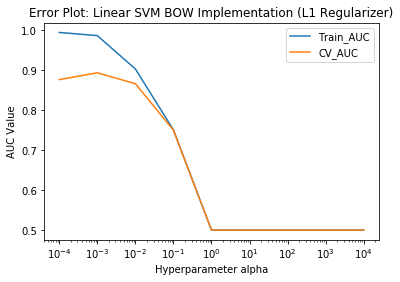

In [49]:
import matplotlib.pyplot as plt

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_BOWL1,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_BOWL1,label='CV_AUC')
plt.xscale('log')

plt.legend()
plt.grid(False)

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM BOW Implementation (L1 Regularizer)')

plt.show()

From the curves plotted above we choose the Best value of alpha on the basis of AUC as a metric such that :
* The AUC value on the CV Dataset is the maximum. 
* The gap between the Train and CV AUC Curves is low. 

Therefore based on these 2 conditions, with the help of the curves above, I can choose the best value of alpha to be 
equal to the following (obtaining the CV AUC as well as the "difference between the Train and CV AUC Values for different values of the hyperparameter alpha :

In [50]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_BOWL1[k],2),"\t", np.round(Train_AUC_BOWL1[k] - CV_AUC_BOWL1[k],3))
optimal_alpha_l1 = alpha_hyperparam[1]

0.88 	 0.118
0.89 	 0.093
0.87 	 0.037
0.75 	 0.001
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0


# Testing with the Test Data for Linear SVM's BOW Representation (For L1 Regularization):-

In [51]:
BOW_A = SGDClassifier(alpha=optimal_alpha_l1,loss='hinge',penalty='l1',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
BOW_A.fit(X_LKTrain_SCBOW,Y_LKTrain)
BOW_Test_L1 = CalibratedClassifierCV(BOW_A,method='sigmoid',cv=10)
BOW_Test_L1.fit(X_LKTrain_SCBOW,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [52]:
Y_LKTrain.shape

(70000,)

In [53]:
print(X_LKTrain_SCBOW.shape)

(70000, 49871)


In [54]:
print(Y_LKTest.shape)

(20000,)


In [55]:
print(X_LKTest_SCBOW.shape)

(20000, 49871)


In [56]:
from sklearn.metrics import roc_curve, auc 

train_fpr1,train_tpr1,threshold = roc_curve(Y_LKTrain,BOW_Test_L1.predict_proba(X_LKTrain_SCBOW)[:,1])
test_fpr1,test_tpr1,threshold = roc_curve(Y_LKTest,BOW_Test_L1.predict_proba(X_LKTest_SCBOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

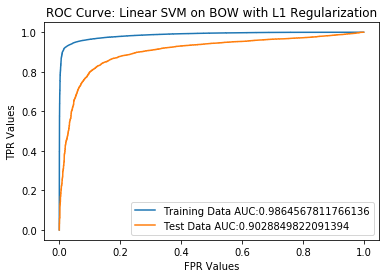

In [57]:
import matplotlib.pyplot as plt

plt.plot(train_fpr1,train_tpr1,label ='Training Data AUC:' + str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label = 'Test Data AUC:' + str(auc(test_fpr1,test_tpr1)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on BOW with L1 Regularization')

plt.grid(False)
plt.show()

In [58]:
Y_Train_pred1 = BOW_Test_L1.predict_proba(X_LKTrain_SCBOW)[:,1]
Y_Test_pred1 = BOW_Test_L1.predict_proba(X_LKTest_SCBOW)[:,1]

<b> <font color="black"> Function to Obtain the Best Threshold & Predictions:- </font> </b>

In [59]:
def matrixpredict(data,thresholds,tpr,fpr):   
    matrixpredict.best_tradeoff = tpr*(1-fpr)
    matrixpredict.ideal_threshold = thresholds[matrixpredict.best_tradeoff.argmax()]
 
    predictions=[]
    
    for i in data:
        if i>= matrixpredict.ideal_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<b> <font color="black"> Function to Plot the Training Confusion Matrix HeatMap:- </font> </b>

In [60]:
import seaborn as sns

def plottrainmatrix (train_matrix):
    sns.set_style("whitegrid")
    
    labels = [0,1]
    
    print("-"*20, "Training Confusion Matrix", "-"*20)
    print(" ")
    print("The Training Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(train_matrix,
                annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()   

<b> <font color="black"> Function to Plot the Test Confusion Matrix HeatMap:- </font> </b>

In [61]:
import seaborn as sns

def plottestmatrix (test_matrix):
    labels = [0,1]
    
    print("-"*20, "Test Data Confusion Matrix", "-"*20)
    print(" ")
    print("The Test Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(test_matrix,annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, 
                yticklabels=labels,annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()     

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.906776484959898
Threshold for Maximum Value of tpr*(1-fpr) : 0.864


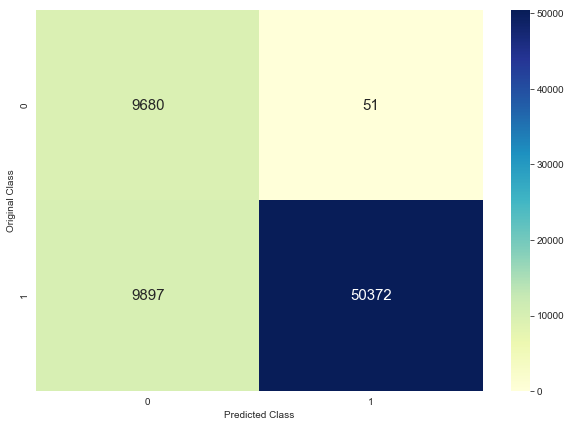

In [62]:
BOW_Train1 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred1,threshold,train_tpr1,train_fpr1))
plottrainmatrix(BOW_Train1)

Accuracy on the Training Data => (50372+9680)/70000 = 85.78%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7251316103866291
Threshold for Maximum Value of tpr*(1-fpr) : 0.851


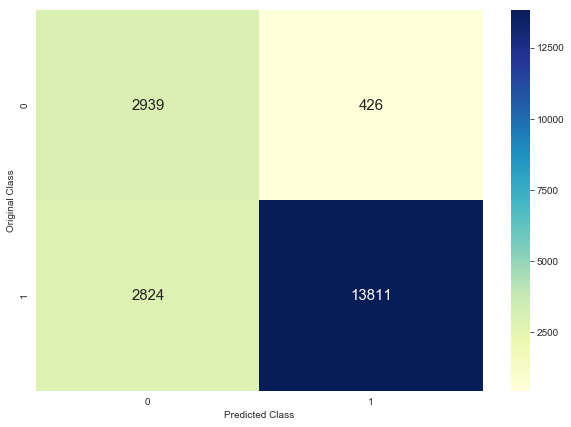

In [63]:
BOW_Test1 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred1,threshold,test_tpr1,test_fpr1))
plottestmatrix(BOW_Test1)

Accuracy on the Test Data => (13811+2939)/20000 = 83.75%

# Applying Linear SVM with L2 regularization on BOW :- 

# Hyperparameter Tuning on the Linear SVM BOW Representation (For L2 Regularization):- 

In [64]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_BOWL2=[]
CV_AUC_BOWL2=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_2 = SGDClassifier(alpha=i,loss='hinge',penalty='l2',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_2.fit(X_LKTrain_SCBOW,Y_LKTrain)
    BOW_model = CalibratedClassifierCV(LKSVM_2,method='sigmoid',cv=10)
    BOW_model.fit(X_LKTrain_SCBOW,Y_LKTrain)
    
    Y_Train_pred2 = BOW_model.predict_proba(X_LKTrain_SCBOW)[:,1]
    Y_CV_pred2 = BOW_model.predict_proba(X_LKCV_SCBOW)[:,1]
    
    Train_AUC_BOWL2.append(roc_auc_score(Y_LKTrain,Y_Train_pred2))
    CV_AUC_BOWL2.append(roc_auc_score(Y_LKCV,Y_CV_pred2))

100%|██████████| 9/9 [03:32<00:00, 33.88s/it]


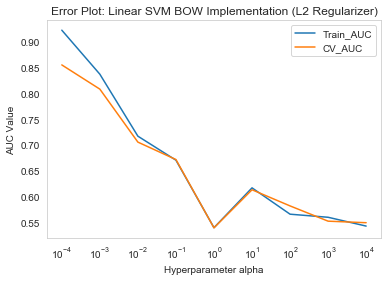

In [65]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_BOWL2,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_BOWL2,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM BOW Implementation (L2 Regularizer)')

plt.grid(False)
plt.show()

In [66]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_BOWL2[k],2),"\t", np.round(Train_AUC_BOWL2[k] - CV_AUC_BOWL2[k],3))
optimal_alpha_l2 = alpha_hyperparam[0]

0.86 	 0.067
0.81 	 0.029
0.71 	 0.012
0.67 	 -0.001
0.54 	 0.0
0.61 	 0.004
0.58 	 -0.016
0.55 	 0.008
0.55 	 -0.007


# Testing with the Test Data for Linear SVM's BOW Representation (For L2 Regularization):-

In [67]:
BOW_B = SGDClassifier(alpha=optimal_alpha_l2,loss='hinge',penalty='l2',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
BOW_B.fit(X_LKTrain_SCBOW,Y_LKTrain)
BOW_Test_L2 = CalibratedClassifierCV(BOW_B,method='sigmoid',cv=10)
BOW_Test_L2.fit(X_LKTrain_SCBOW,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [68]:
from sklearn.metrics import roc_curve, auc 

train_fpr2,train_tpr2,threshold = roc_curve(Y_LKTrain,BOW_Test_L2.predict_proba(X_LKTrain_SCBOW)[:,1])
test_fpr2,test_tpr2,threshold = roc_curve(Y_LKTest,BOW_Test_L2.predict_proba(X_LKTest_SCBOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

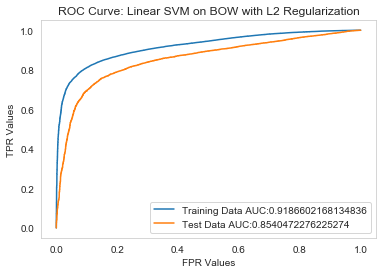

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2,label ='Training Data AUC:' + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label = 'Test Data AUC:' + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on BOW with L2 Regularization')

plt.grid(False)
plt.show()

In [70]:
Y_Train_pred2 = BOW_Test_L2.predict_proba(X_LKTrain_SCBOW)[:,1]
Y_Test_pred2 = BOW_Test_L2.predict_proba(X_LKTest_SCBOW)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7299735565877219
Threshold for Maximum Value of tpr*(1-fpr) : 0.847


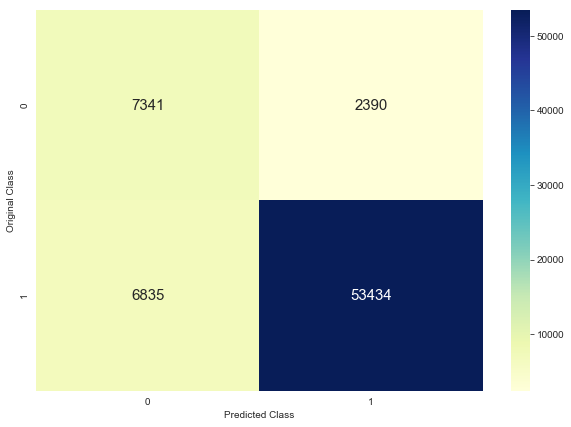

In [71]:
BOW_Train2 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred2,threshold,train_tpr2,train_fpr2))
plottrainmatrix(BOW_Train2)

Accuracy on the Training Data => (53434+7341)/70000 = 86.82%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6448304676359079
Threshold for Maximum Value of tpr*(1-fpr) : 0.862


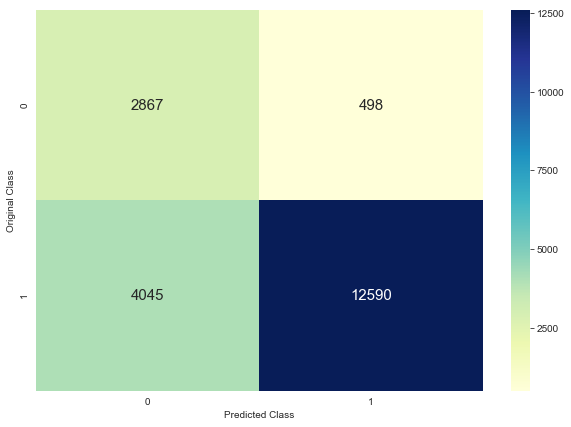

In [72]:
BOW_Test2 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred2,threshold,test_tpr2,test_fpr2))
plottestmatrix(BOW_Test2)

Accuracy on the Test Data => (12590+2867)/20000 = 77.28%

# Top 10 Positive & Negative Features with Linear SVM & BOW Featurization:- 

#  Top 10 Positive Features with Linear SVM & BOW Featurization  :-

In [74]:
BOW_feature_names = count_vect.get_feature_names()
BOW_weights = BOW_A.coef_.reshape(-1)
BOW_features = np.argsort(BOW_weights)
BOW_features_sorted = np.flip(BOW_features)

print("The Top 10 Features of the Positive Class and their corresponding weights are as follows:")
print("="*100)
for i in BOW_features_sorted[0:10]:
    print("%s\t-->\t%f"%(BOW_feature_names[i], BOW_weights[i]))

The Top 10 Features of the Positive Class and their corresponding weights are as follows:
great	-->	2774.244174
delicious	-->	2505.499682
perfect	-->	2202.633454
best	-->	2196.659779
highly	-->	1869.482587
excellent	-->	1562.360386
good	-->	1507.835377
wonderful	-->	1500.014966
nice	-->	1361.047455
easy	-->	1314.577030


#  Top 10 Negative Features with Linear SVM & BOW Featurization  :-

In [75]:
print("The Top 10 Features of the Negative Class and their corresponding weights are as follows:")
print("="*100)
for i in BOW_features[0:10]:
    print("%s\t-->\t%f"%(BOW_feature_names[i], BOW_weights[i]))

The Top 10 Features of the Negative Class and their corresponding weights are as follows:
not	-->	-2827.479429
akg	-->	-1878.731904
contaminates	-->	-1502.591262
senna	-->	-1491.482071
unharmed	-->	-1383.250857
blotches	-->	-1381.264857
crosswise	-->	-1346.143597
chuao	-->	-1343.180200
defibrillator	-->	-1343.036200
shekels	-->	-1342.558200


# [5.1.2] SET 2 : Applying Linear SVM on TFIDF :-

In [76]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_LKTrain)

# Again fit is carried out only on the Training data. fit() internally stores the parameters that will be used to 
#convert the Text to a numerical vector. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [77]:
X_LKTrain_TFIDF = tf_idf_vect.transform(X_LKTrain)
X_LKCV_TFIDF = tf_idf_vect.transform(X_LKCV)
X_LKTest_TFIDF = tf_idf_vect.transform(X_LKTest)

In [78]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_LKTrain.shape,Y_LKTrain.shape)
print(X_LKCV.shape,Y_LKCV.shape)
print(X_LKTest.shape,Y_LKTest.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_LKTrain_TFIDF.shape,Y_LKTrain.shape)
print(X_LKCV_TFIDF.shape,Y_LKCV.shape)
print(X_LKTest_TFIDF.shape,Y_LKTest.shape)

Shapes before the TFIDF Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes after the TFIDF Vectorization was carried out:
(70000, 40652) (70000,)
(10000, 40652) (10000,)
(20000, 40652) (20000,)


# Applying Linear SVM with L1 regularization on TFIDF :- 

# Hyperparameter Tuning on the Linear SVM TFIDF Representation (For L1 Regularization):- 

In [79]:
warnings.filterwarnings('ignore')

Scaler2 = StandardScaler(with_mean=False)

X_LKTrain_SCTFIDF = Scaler2.fit_transform(X_LKTrain_TFIDF)
X_LKCV_SCTFIDF = Scaler2.transform(X_LKCV_TFIDF)
X_LKTest_SCTFIDF = Scaler2.transform(X_LKTest_TFIDF)

In [80]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_TFIDFL1=[]
CV_AUC_TFIDFL1=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_2 = SGDClassifier(alpha=i,loss='hinge',penalty='l1',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_2.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
    TFIDF_model = CalibratedClassifierCV(LKSVM_2,method='sigmoid',cv=10)
    TFIDF_model.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
    
    Y_Train_pred3 = TFIDF_model.predict_proba(X_LKTrain_SCTFIDF)[:,1]
    Y_CV_pred3 = TFIDF_model.predict_proba(X_LKCV_SCTFIDF)[:,1]
    
    Train_AUC_TFIDFL1.append(roc_auc_score(Y_LKTrain,Y_Train_pred3))
    CV_AUC_TFIDFL1.append(roc_auc_score(Y_LKCV,Y_CV_pred3))

100%|██████████| 9/9 [00:32<00:00,  3.51s/it]


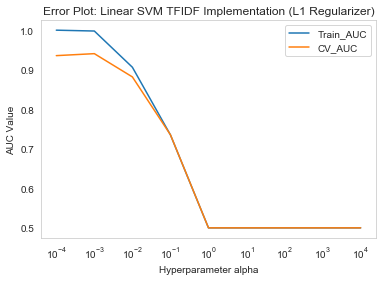

In [81]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_TFIDFL1,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_TFIDFL1,label='CV_AUC')

plt.legend()
plt.xscale('log')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM TFIDF Implementation (L1 Regularizer)')

plt.grid(False)
plt.show()

In [82]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_TFIDFL1[k],2),"\t", np.round(Train_AUC_TFIDFL1[k] - CV_AUC_TFIDFL1[k],3))
optimal_alpha_TFIDF_L1 = alpha_hyperparam[1]

0.94 	 0.064
0.94 	 0.057
0.88 	 0.024
0.74 	 -0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0


# Testing with the Test Data for Linear SVM's TFIDF Representation (For L1 Regularization):-

In [83]:
TFIDF_A = SGDClassifier(alpha=optimal_alpha_TFIDF_L1,loss='hinge',penalty='l1',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
TFIDF_A.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
TFIDF_Test_L1 = CalibratedClassifierCV(TFIDF_A,method='sigmoid',cv=10)
TFIDF_Test_L1.fit(X_LKTrain_SCTFIDF,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [84]:
from sklearn.metrics import roc_curve, auc 

train_fpr3,train_tpr3,threshold = roc_curve(Y_LKTrain,TFIDF_Test_L1.predict_proba(X_LKTrain_SCTFIDF)[:,1])
test_fpr3,test_tpr3,threshold = roc_curve(Y_LKTest,TFIDF_Test_L1.predict_proba(X_LKTest_SCTFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

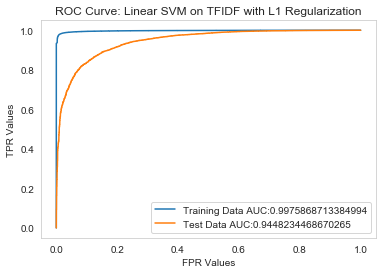

In [85]:
import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3,label ='Training Data AUC:' + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3,label = 'Test Data AUC:' + str(auc(test_fpr3,test_tpr3)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on TFIDF with L1 Regularization')

plt.grid(False)
plt.show()

In [86]:
Y_Train_pred3 = TFIDF_Test_L1.predict_proba(X_LKTrain_SCTFIDF)[:,1]
Y_Test_pred3 = TFIDF_Test_L1.predict_proba(X_LKTest_SCTFIDF)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.9693091708821315
Threshold for Maximum Value of tpr*(1-fpr) : 0.911


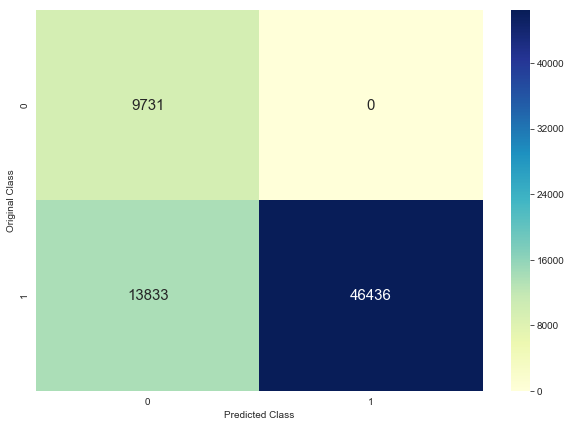

In [87]:
TFIDF_Train1 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred3,threshold,train_tpr3,train_fpr3))
plottrainmatrix(TFIDF_Train1)

Accuracy on the Training Data => (46436+9731)/70000 = 80.23% 

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7581547704382755
Threshold for Maximum Value of tpr*(1-fpr) : 0.835


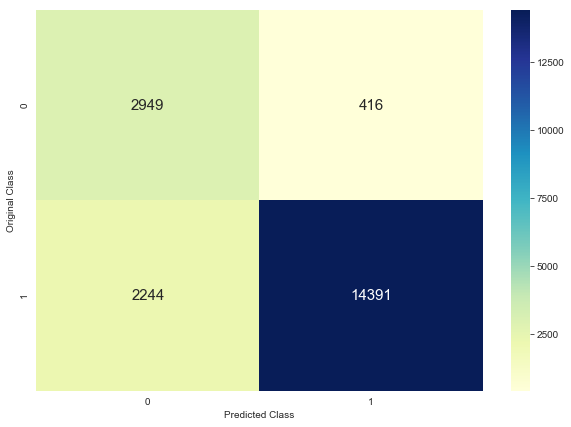

In [88]:
TFIDF_Test1 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred3,threshold,test_tpr3,test_fpr3))
plottestmatrix(TFIDF_Test1)

Accuracy on the Test Data => (14391+2949)/20000 = 86.70%

# Applying Linear SVM with L2 regularization on TFIDF :- 

# Hyperparameter Tuning on the Linear SVM TFIDF Representation (For L2 Regularization):- 

In [89]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_TFIDFL2=[]
CV_AUC_TFIDFL2=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_2 = SGDClassifier(alpha=i,loss='hinge',penalty='l2',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_2.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
    TFIDF_model = CalibratedClassifierCV(LKSVM_2,method='sigmoid',cv=10)
    TFIDF_model.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
    
    Y_Train_pred4 = TFIDF_model.predict_proba(X_LKTrain_SCTFIDF)[:,1]
    Y_CV_pred4 = TFIDF_model.predict_proba(X_LKCV_SCTFIDF)[:,1]
    
    Train_AUC_TFIDFL2.append(roc_auc_score(Y_LKTrain,Y_Train_pred4))
    CV_AUC_TFIDFL2.append(roc_auc_score(Y_LKCV,Y_CV_pred4))

100%|██████████| 9/9 [03:12<00:00, 30.08s/it]


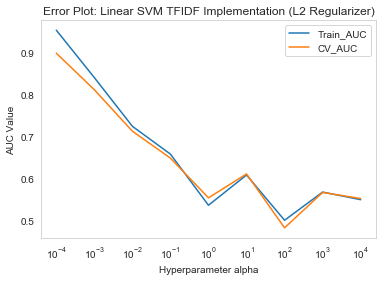

In [90]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_TFIDFL2,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_TFIDFL2,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM TFIDF Implementation (L2 Regularizer)')

plt.grid(False)
plt.show()

In [91]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_TFIDFL2[k],2),"\t", np.round(Train_AUC_TFIDFL2[k] - CV_AUC_TFIDFL2[k],3))
optimal_alpha_TFIDF_L2 = alpha_hyperparam[0]

0.9 	 0.055
0.81 	 0.029
0.71 	 0.012
0.65 	 0.01
0.55 	 -0.018
0.61 	 -0.003
0.48 	 0.018
0.57 	 0.001
0.55 	 -0.003


# Testing with the Test Data for Linear SVM's TFIDF Representation (For L2 Regularization):-

In [92]:
TFIDF_B = SGDClassifier(alpha=optimal_alpha_TFIDF_L2,loss='hinge',penalty='l2',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
TFIDF_B.fit(X_LKTrain_SCTFIDF,Y_LKTrain)
TFIDF_Test_L2 = CalibratedClassifierCV(TFIDF_B,method='sigmoid',cv=10)
TFIDF_Test_L2.fit(X_LKTrain_SCTFIDF,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [93]:
from sklearn.metrics import roc_curve, auc 

train_fpr4,train_tpr4,threshold = roc_curve(Y_LKTrain,TFIDF_Test_L2.predict_proba(X_LKTrain_SCTFIDF)[:,1])
test_fpr4,test_tpr4,threshold = roc_curve(Y_LKTest,TFIDF_Test_L2.predict_proba(X_LKTest_SCTFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

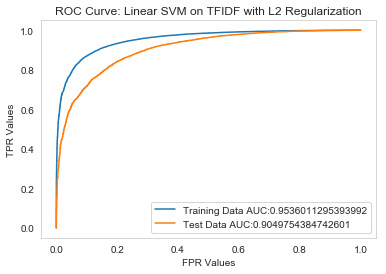

In [94]:
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4,label ='Training Data AUC:' + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4,label = 'Test Data AUC:' + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on TFIDF with L2 Regularization')

plt.grid(False)
plt.show()

In [95]:
Y_Train_pred4 = TFIDF_Test_L2.predict_proba(X_LKTrain_SCTFIDF)[:,1]
Y_Test_pred4 = TFIDF_Test_L2.predict_proba(X_LKTest_SCTFIDF)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7834603972002417
Threshold for Maximum Value of tpr*(1-fpr) : 0.798


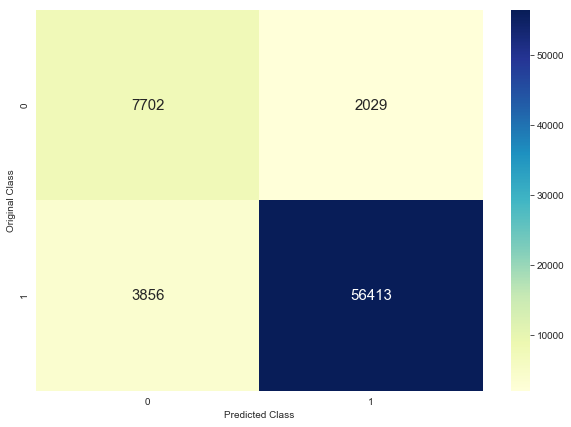

In [96]:
TFIDF_Train2 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred4,threshold,train_tpr4,train_fpr4))
plottrainmatrix(TFIDF_Train2)

Accuracy on Training Data => (56413+7702)/70000 = 91.59%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6751057737785001
Threshold for Maximum Value of tpr*(1-fpr) : 0.832


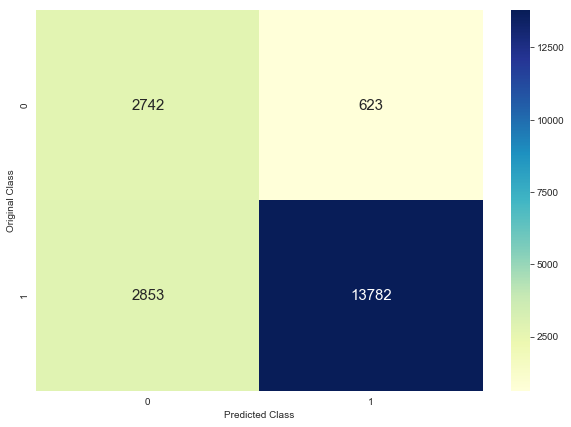

In [97]:
TFIDF_Test2 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred4,threshold,test_tpr4,test_fpr4))
plottestmatrix(TFIDF_Test2)

Accuracy on the Test Data => (13782+2742)/20000 = 82.62%

# Top 10 Positive & Negative Features with Linear SVM & TFIDF Featurization:- 

#  Top 10 Positive Features with Linear SVM & TFIDF Featurization  :-

In [98]:
TFIDF_feature_names = tf_idf_vect.get_feature_names()
TFIDF_weights = TFIDF_B.coef_.reshape(-1)
TFIDF_features = np.argsort(TFIDF_weights)
TFIDF_features_sorted = np.flip(TFIDF_features)

print("The Top 10 Features of the Positive Class and their corresponding weights are as follows:")
print("="*100)
for i in TFIDF_features_sorted[0:10]:
    print("%s\t-->\t%f"%(TFIDF_feature_names[i],TFIDF_weights[i]))

The Top 10 Features of the Positive Class and their corresponding weights are as follows:
great	-->	321.545421
delicious	-->	300.306186
water process	-->	285.934402
love	-->	236.007693
best	-->	221.398644
favorite	-->	220.993118
definitely	-->	216.600899
cream rice	-->	213.744509
tasty	-->	213.465252
wonderful	-->	208.501354


#  Top 10 Negative Features with Linear SVM & TFIDF Featurization  :-

In [99]:
print("The Top 10 Features of the Negative Class and their corresponding weights are as follows:")
print("="*100)
for i in TFIDF_features[0:10]:
    print("%s\t-->\t%f"%(TFIDF_feature_names[i],TFIDF_weights[i]))

The Top 10 Features of the Negative Class and their corresponding weights are as follows:
tell really	-->	-956.505751
everyday not	-->	-935.038467
using pods	-->	-850.843338
smaller normal	-->	-849.815088
used date	-->	-769.121482
strong cinnamon	-->	-766.484921
germinate	-->	-760.187393
shipping way	-->	-739.685189
intestine	-->	-731.826446
large variety	-->	-723.862051


# [5.1.3] SET 3 : Applying Linear SVM on Avg W2V :-

# Converting Reviews into Numerical Vectors using W2V vectors :-

In [100]:
list_of_sentence_Train =[]

for sentence in X_LKTrain:
    list_of_sentence_Train.append(sentence.split())

In [101]:
w2v_model=Word2Vec(list_of_sentence_Train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occur a minimum 5 times :",len(w2v_words))
print("Some of the sample words are as follows: ", w2v_words[0:50])

Number of words that occur a minimum 5 times : 15928
Some of the sample words are as follows:  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd']


# Converting the Train Data Text :-

In [102]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 70000/70000 [03:26<00:00, 338.18it/s]


(70000, 50)
[-0.14938247 -0.43137136  0.01303679  0.42516203 -0.25576141 -0.15039817
  0.18813432  0.42089705  0.26268179 -0.27547325 -0.08321425  0.29440326
  0.30498686 -0.03815303  0.6398792   0.11416545  0.15596607  0.40130977
 -0.22507206  0.76037855  0.02293459 -0.01694738  0.10923793  0.03269501
 -0.27133875  0.36402021 -0.04193874 -0.0687579  -0.35566333  0.24847272
 -0.4175689   0.27436721  0.12734491  0.20098708  0.2189834  -0.17605226
 -0.44339338  0.30354532 -0.21933309 -0.13802178  0.08273564 -0.19383385
 -0.23799234 -0.10374606 -0.338405    0.06996489  0.27204797  0.33009543
  0.27052905  0.27508248]


# Converting the CV Data Text :- 

In [103]:
list_of_sentence_CV=[]

for sentence in X_LKCV:
    list_of_sentence_CV.append(sentence.split())

In [104]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 10000/10000 [00:32<00:00, 307.42it/s]

(10000, 50)
[-0.39692    -0.50783466  0.68509579  0.29900568  0.15250216 -0.34877761
 -0.60317951  0.40509071  0.60281591 -0.10869374 -0.07300171 -0.73900724
 -0.91207977 -0.45367088  1.0695313   0.64156793  0.59547171  0.13983581
 -0.40724643  0.17765888 -0.40816366  0.94450423 -0.83400127 -1.03229045
 -0.85141723  0.01338985 -0.72743173  0.47404336 -0.76994349  0.23007954
 -0.15520952  0.90659454 -0.02451806  0.21405259  0.15843016 -0.0022629
 -0.22568919  0.65963379 -0.15055756 -0.32515431 -0.04387177 -0.48397925
 -0.39197717  0.07824978 -0.34345252  0.32742974 -0.49878844 -0.11597205
 -0.95488499  0.41504232]


# Converting the Test Dataset :- 

In [105]:
list_of_sentence_Test=[]

for sentence in X_LKTest:
    list_of_sentence_Test.append(sentence.split())

In [106]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 20000/20000 [01:03<00:00, 314.84it/s]

(20000, 50)
[-0.17383173 -0.19569612 -0.47760681  0.88585097 -0.26067707 -0.56999673
  0.13880457 -0.63195631 -1.16445275 -0.45011984 -0.83841507 -0.44315554
 -0.07475294 -0.21174659  1.21184085  0.43699243  0.93129531  0.38796403
  0.01169469  0.69019524 -0.27248086  0.17924181 -0.29637764  0.23592196
 -0.00637694 -0.16461166 -0.72961043  0.40518132 -0.0712661   0.51659543
 -0.14199147  0.3713178   0.19118271 -0.19006475 -0.16651374 -0.32702944
 -0.55652665 -0.27036862 -0.67801017  0.25626279  0.48662849  0.4754886
 -0.4735084   0.44597335 -0.46560049 -0.0712376  -0.48753355  0.17923142
  0.58342281  0.13629912]


In [107]:
print("Shapes before the Avg W2V Vectorization was carried out:")

print(X_LKTrain.shape,Y_LKTrain.shape)
print(X_LKCV.shape,Y_LKCV.shape)
print(X_LKTest.shape,Y_LKTest.shape)

print("="*100)

print("Shapes after the Avg W2V Vectorization was carried out:")

print(sent_vectors_train.shape,Y_LKTrain.shape)
print(sent_vectors_cv.shape,Y_LKCV.shape)
print(sent_vectors_test.shape,Y_LKTest.shape)

Shapes before the Avg W2V Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes after the Avg W2V Vectorization was carried out:
(70000, 50) (70000,)
(10000, 50) (10000,)
(20000, 50) (20000,)


# Applying Linear SVM with L1 regularization on Avg W2V :- 

# Hyperparameter Tuning on the Linear SVM Avg W2V Representation (For L1 Regularization):- 

In [108]:
Scaler3 = StandardScaler(with_mean=False)

X_LKTrain_SCAW2V = Scaler3.fit_transform(sent_vectors_train)
X_LKCV_SCAW2V = Scaler3.transform(sent_vectors_cv)
X_LKTest_SCAW2V = Scaler3.transform(sent_vectors_test)

In [109]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_AW2VL1=[]
CV_AUC_AW2VL1=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_3 = SGDClassifier(alpha=i,loss='hinge',penalty='l1',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_3.fit(X_LKTrain_SCAW2V,Y_LKTrain)
    AW2V_model = CalibratedClassifierCV(LKSVM_3,method='sigmoid',cv=10)
    AW2V_model.fit(X_LKTrain_SCAW2V,Y_LKTrain)
    
    Y_Train_pred5 = AW2V_model.predict_proba(X_LKTrain_SCAW2V)[:,1]
    Y_CV_pred5 = AW2V_model.predict_proba(X_LKCV_SCAW2V)[:,1]
    
    Train_AUC_AW2VL1.append(roc_auc_score(Y_LKTrain,Y_Train_pred5))
    CV_AUC_AW2VL1.append(roc_auc_score(Y_LKCV,Y_CV_pred5))

100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


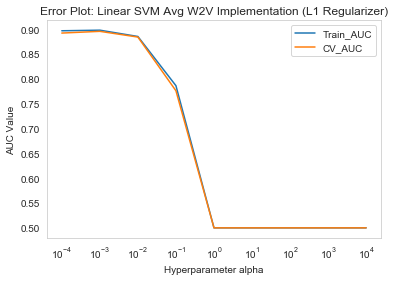

In [110]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_AW2VL1,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_AW2VL1,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM Avg W2V Implementation (L1 Regularizer)')

plt.grid(False)
plt.show()

In [111]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_AW2VL1[k],2),"\t", np.round(Train_AUC_AW2VL1[k] - CV_AUC_AW2VL1[k],3))
optimal_alpha_AW2V_L1 = alpha_hyperparam[2]

0.89 	 0.005
0.9 	 0.002
0.88 	 0.001
0.78 	 0.01
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0


# Testing with the Test Data for Linear SVM's Avg W2V Representation (For L1 Regularization) :-

In [112]:
AW2V_A = SGDClassifier(alpha=optimal_alpha_AW2V_L1,loss='hinge',penalty='l1',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
AW2V_A.fit(X_LKTrain_SCAW2V,Y_LKTrain)
AW2V_Test_L1 = CalibratedClassifierCV(AW2V_A,method='sigmoid',cv=10)
AW2V_Test_L1.fit(X_LKTrain_SCAW2V,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [113]:
from sklearn.metrics import roc_curve, auc 

train_fpr5,train_tpr5,threshold = roc_curve(Y_LKTrain,AW2V_Test_L1.predict_proba(X_LKTrain_SCAW2V)[:,1])
test_fpr5,test_tpr5,threshold = roc_curve(Y_LKTest,AW2V_Test_L1.predict_proba(X_LKTest_SCAW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

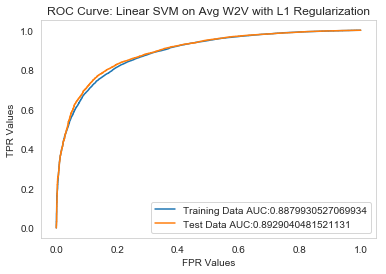

In [114]:
import matplotlib.pyplot as plt

plt.plot(train_fpr5,train_tpr5,label ='Training Data AUC:' + str(auc(train_fpr5,train_tpr5)))
plt.plot(test_fpr5,test_tpr5,label = 'Test Data AUC:' + str(auc(test_fpr5,test_tpr5)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on Avg W2V with L1 Regularization')

plt.grid(False)
plt.show()

In [115]:
Y_Train_pred5 = AW2V_Test_L1.predict_proba(X_LKTrain_SCAW2V)[:,1]
Y_Test_pred5 = AW2V_Test_L1.predict_proba(X_LKTest_SCAW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6521828874024641
Threshold for Maximum Value of tpr*(1-fpr) : 0.358


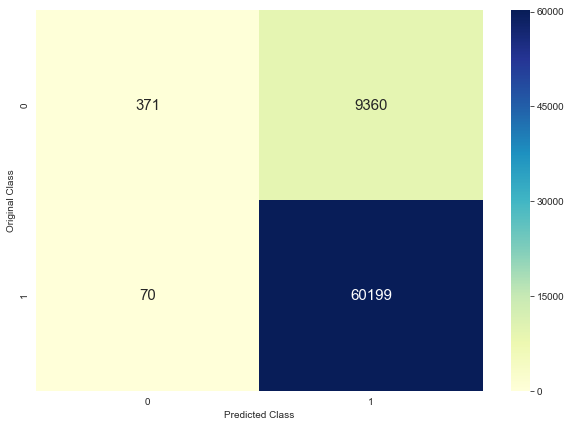

In [116]:
AW2V_Train1 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred5,threshold,train_tpr5,train_fpr5))
plottrainmatrix(AW2V_Train1)

Accuracy on Training Data => (60199+371)/70000 = 86.52%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6674644796882279
Threshold for Maximum Value of tpr*(1-fpr) : 0.832


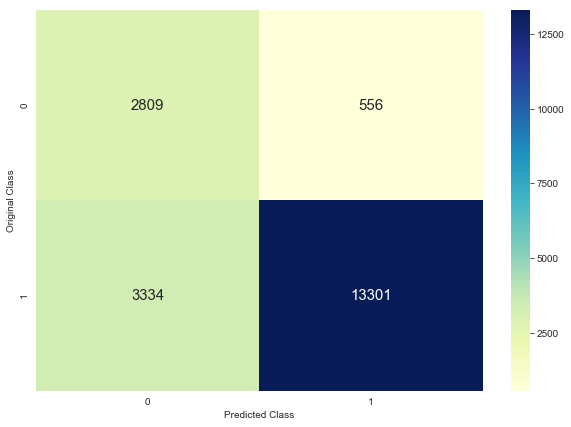

In [117]:
AW2V_Test1 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred5,threshold,test_tpr5,test_fpr5))
plottestmatrix(AW2V_Test1)

Accuracy on the Test Data => (13301+2809)/20000 = 80.55%

# Applying Linear SVM with L2 regularization on Avg W2V :- 

# Hyperparameter Tuning on the Linear SVM Avg W2V Representation (For L2 Regularization):- 

In [118]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_AW2VL2=[]
CV_AUC_AW2VL2=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_3 = SGDClassifier(alpha=i,loss='hinge',penalty='l2',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_3.fit(X_LKTrain_SCAW2V,Y_LKTrain)
    AW2V_model = CalibratedClassifierCV(LKSVM_3,method='sigmoid',cv=10)
    AW2V_model.fit(X_LKTrain_SCAW2V,Y_LKTrain)
    
    Y_Train_pred6 = AW2V_model.predict_proba(X_LKTrain_SCAW2V)[:,1]
    Y_CV_pred6 = AW2V_model.predict_proba(X_LKCV_SCAW2V)[:,1]
    
    Train_AUC_AW2VL2.append(roc_auc_score(Y_LKTrain,Y_Train_pred6))
    CV_AUC_AW2VL2.append(roc_auc_score(Y_LKCV,Y_CV_pred6))

100%|██████████| 9/9 [00:13<00:00,  1.52s/it]


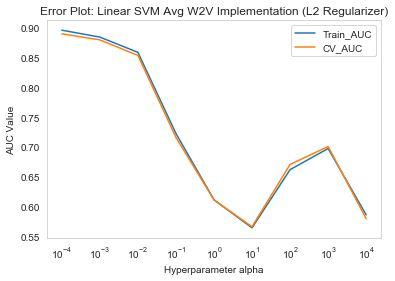

In [119]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_AW2VL2,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_AW2VL2,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM Avg W2V Implementation (L2 Regularizer)')

plt.grid(False)
plt.show()

In [120]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_AW2VL2[k],2),"\t", np.round(Train_AUC_AW2VL2[k] - CV_AUC_AW2VL2[k],3))
optimal_alpha_AW2V_L2 = alpha_hyperparam[0]

0.89 	 0.006
0.88 	 0.005
0.85 	 0.005
0.72 	 0.007
0.61 	 0.0
0.57 	 -0.002
0.67 	 -0.009
0.7 	 -0.003
0.58 	 0.006


# Testing with the Test Data for Linear SVM's Avg W2V Representation (For L2 Regularization) :-

In [121]:
AW2V_B = SGDClassifier(alpha=optimal_alpha_AW2V_L2,loss='hinge',penalty='l2',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
AW2V_B.fit(X_LKTrain_SCAW2V,Y_LKTrain)
AW2V_Test_L2 = CalibratedClassifierCV(AW2V_B,method='sigmoid',cv=10)
AW2V_Test_L2.fit(X_LKTrain_SCAW2V,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [122]:
from sklearn.metrics import roc_curve, auc 

train_fpr6,train_tpr6,threshold = roc_curve(Y_LKTrain,AW2V_Test_L2.predict_proba(X_LKTrain_SCAW2V)[:,1])
test_fpr6,test_tpr6,threshold = roc_curve(Y_LKTest,AW2V_Test_L2.predict_proba(X_LKTest_SCAW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

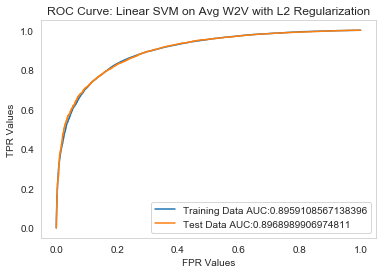

In [123]:
import matplotlib.pyplot as plt

plt.plot(train_fpr6,train_tpr6,label ='Training Data AUC:' + str(auc(train_fpr6,train_tpr6)))
plt.plot(test_fpr6,test_tpr6,label = 'Test Data AUC:' + str(auc(test_fpr6,test_tpr6)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on Avg W2V with L2 Regularization')

plt.grid(False)
plt.show()

In [124]:
Y_Train_pred6 = AW2V_Test_L2.predict_proba(X_LKTrain_SCAW2V)[:,1]
Y_Test_pred6 = AW2V_Test_L2.predict_proba(X_LKTest_SCAW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6669171917055817
Threshold for Maximum Value of tpr*(1-fpr) : 0.424


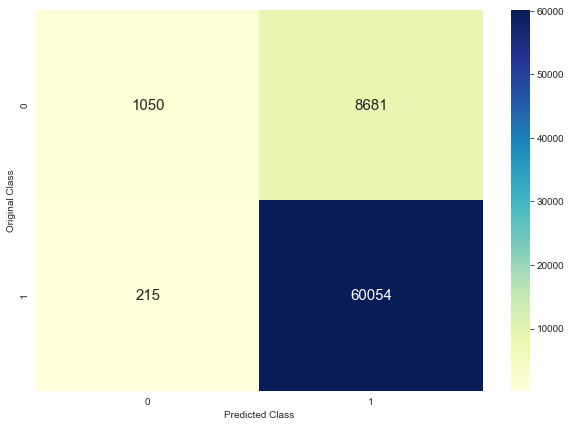

In [125]:
AW2V_Train2 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred6,threshold,train_tpr6,train_fpr6))
plottrainmatrix(AW2V_Train2)

Accuracy on Training Data => (60054+1050)/70000 = 87.29%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6642918246004705
Threshold for Maximum Value of tpr*(1-fpr) : 0.83


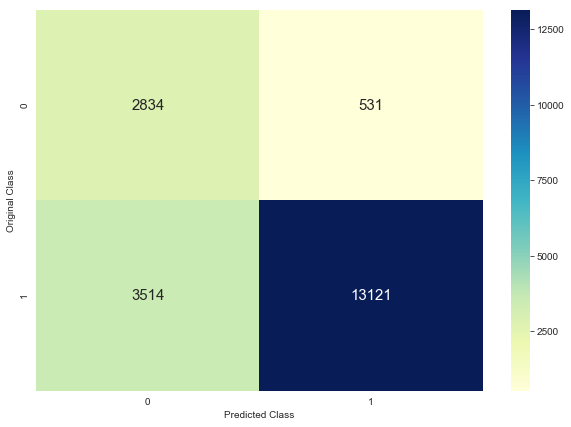

In [126]:
AW2V_Test2 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred6,threshold,test_tpr6,test_fpr6))
plottestmatrix(AW2V_Test2)

Accuracy on the Test Data => (13121+2834)/20000 = 79.77%

# [5.1.4] SET 4 : Applying Linear SVM on TFIDF W2V :-

In [127]:
model_LK = TfidfVectorizer()
tf_idf_matrix = model_LK.fit_transform(X_LKTrain)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_LK.get_feature_names(), list(model_LK.idf_)))

In [128]:
tf_idf_matrix.shape

(70000, 49871)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [129]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_LK.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_LKtrain = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_LKtrain.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [52:22<00:00, 22.27it/s]  


In [130]:
tfidf_sent_vectors_LKtrain[1]

array([-0.34247471, -0.39397753, -0.00569014,  0.4497053 , -0.3467407 ,
       -0.4384041 , -0.0257477 ,  0.2078572 ,  0.61916946, -0.1400447 ,
       -0.27642973,  0.04508289, -0.14778356, -0.28724021,  0.48512615,
       -0.30125135,  0.36689042,  0.43943402,  0.10970153,  0.80763873,
       -0.11237329,  0.01549892,  0.1126221 ,  0.24850639, -0.43740891,
       -0.10016553,  0.08680905, -0.3782432 , -0.41628391, -0.3027296 ,
       -0.31163167,  0.31823103,  0.38612504, -0.09451048,  0.16412383,
        0.11087739, -0.3283484 ,  0.19024235, -0.56311525, -0.42084858,
        0.0795899 , -0.11752314, -0.24729606, -0.11179155, -0.26011029,
       -0.0830757 ,  0.52295371,  0.17165635,  0.16535114,  0.25870963])

# Converting the CV Data Text :-

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_LK.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_LKCV = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_LKCV.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [07:41<00:00, 21.67it/s]


# Converting the Test Data Text :-

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_LK.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_LKtest = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_LKtest.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [15:06<00:00, 22.07it/s]


# Applying Linear SVM with L1 regularization on TFIDF W2V :- 

# Hyperparameter Tuning on the Linear SVM TFIDF W2V Representation (For L1 Regularization):- 

In [133]:
Scaler4 = StandardScaler(with_mean=False)

X_LKTrain_SCTFIDFW2V = Scaler3.fit_transform(tfidf_sent_vectors_LKtrain)
X_LKCV_SCTFIDFW2V = Scaler3.transform(tfidf_sent_vectors_LKCV)
X_LKTest_SCTFIDFW2V = Scaler3.transform(tfidf_sent_vectors_LKtest)

In [134]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_TFIDFW2VL1=[]
CV_AUC_TFIDFW2VL1=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_4 = SGDClassifier(alpha=i,loss='hinge',penalty='l1',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_4.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
    TFIDFW2V_model = CalibratedClassifierCV(LKSVM_4,method='sigmoid',cv=10)
    TFIDFW2V_model.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
    
    Y_Train_pred7 = TFIDFW2V_model.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1]
    Y_CV_pred7 = TFIDFW2V_model.predict_proba(X_LKCV_SCTFIDFW2V)[:,1]
    
    Train_AUC_TFIDFW2VL1.append(roc_auc_score(Y_LKTrain,Y_Train_pred7))
    CV_AUC_TFIDFW2VL1.append(roc_auc_score(Y_LKCV,Y_CV_pred7))

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


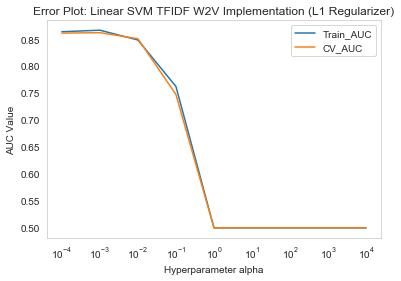

In [135]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_TFIDFW2VL1,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_TFIDFW2VL1,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM TFIDF W2V Implementation (L1 Regularizer)')

plt.grid(False)
plt.show()

In [136]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_TFIDFW2VL1[k],2),"\t", np.round(Train_AUC_TFIDFW2VL1[k] - CV_AUC_TFIDFW2VL1[k],3))
optimal_alpha_TFIDFW2V_L1 = alpha_hyperparam[0]

0.86 	 0.003
0.86 	 0.005
0.85 	 -0.002
0.75 	 0.015
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0
0.5 	 0.0


# Testing with the Test Data for Linear SVM's TFIDF W2V Representation (For L1 Regularization) :-

In [137]:
TFIDFW2V_A = SGDClassifier(alpha=optimal_alpha_TFIDFW2V_L1,loss='hinge',penalty='l1',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
TFIDFW2V_A.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
TFIDFW2V_Test_L1 = CalibratedClassifierCV(TFIDFW2V_A,method='sigmoid',cv=10)
TFIDFW2V_Test_L1.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [138]:
from sklearn.metrics import roc_curve, auc 

train_fpr7,train_tpr7,threshold = roc_curve(Y_LKTrain,TFIDFW2V_Test_L1.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1])
test_fpr7,test_tpr7,threshold = roc_curve(Y_LKTest,TFIDFW2V_Test_L1.predict_proba(X_LKTest_SCTFIDFW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

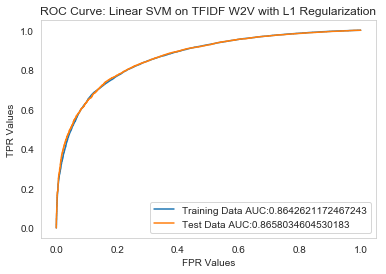

In [139]:
import matplotlib.pyplot as plt

plt.plot(train_fpr7,train_tpr7,label ='Training Data AUC:' + str(auc(train_fpr7,train_tpr7)))
plt.plot(test_fpr7,test_tpr7,label = 'Test Data AUC:' + str(auc(test_fpr7,test_tpr7)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on TFIDF W2V with L1 Regularization')

plt.grid(False)
plt.show()

In [140]:
Y_Train_pred7 = TFIDFW2V_Test_L1.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1]
Y_Test_pred7 = TFIDFW2V_Test_L1.predict_proba(X_LKTest_SCTFIDFW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6155275120386985
Threshold for Maximum Value of tpr*(1-fpr) : 0.63


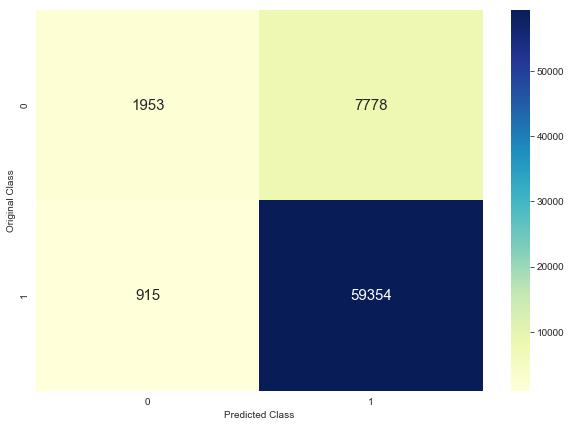

In [141]:
TFIDFW2V_Train1 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred7,threshold,train_tpr7,train_fpr7))
plottrainmatrix(TFIDFW2V_Train1)

Accuracy on Training Data => (59354+1953)/70000 = 87.58%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6207754555349071
Threshold for Maximum Value of tpr*(1-fpr) : 0.841


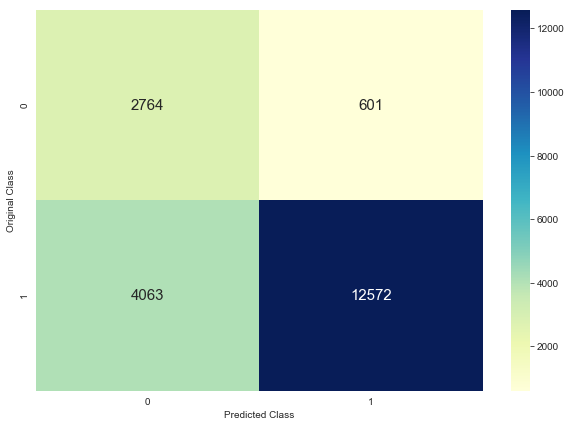

In [142]:
TFIDFW2V_Test1 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred7,threshold,test_tpr7,test_fpr7))
plottestmatrix(TFIDFW2V_Test1)

Accuracy on the Test Data => (12572+2764)/20000 = 76.68%

# Applying Linear SVM with L2 regularization on TFIDF W2V :- 

# Hyperparameter Tuning on the Linear SVM TFIDF W2V Representation (For L2 Regularization):- 

In [143]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

Train_AUC_TFIDFW2VL2=[]
CV_AUC_TFIDFW2VL2=[]

for i in tqdm(alpha_hyperparam):
    LKSVM_4 = SGDClassifier(alpha=i,loss='hinge',penalty='l2',class_weight='balanced',learning_rate='adaptive',
                            eta0=2.0,n_jobs=-1)
    LKSVM_4.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
    TFIDFW2V_model = CalibratedClassifierCV(LKSVM_4,method='sigmoid',cv=10)
    TFIDFW2V_model.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
    
    Y_Train_pred8 = TFIDFW2V_model.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1]
    Y_CV_pred8 = TFIDFW2V_model.predict_proba(X_LKCV_SCTFIDFW2V)[:,1]
    
    Train_AUC_TFIDFW2VL2.append(roc_auc_score(Y_LKTrain,Y_Train_pred8))
    CV_AUC_TFIDFW2VL2.append(roc_auc_score(Y_LKCV,Y_CV_pred8))

100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


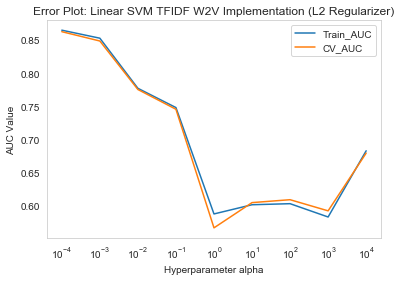

In [144]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(alpha_hyperparam,Train_AUC_TFIDFW2VL2,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(alpha_hyperparam,CV_AUC_TFIDFW2VL2,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: Linear SVM TFIDF W2V Implementation (L2 Regularizer)')

plt.grid(False)
plt.show()

In [145]:
for k in range(0,len(alpha_hyperparam)):
    print(np.round(CV_AUC_TFIDFW2VL2[k],2),"\t", np.round(Train_AUC_TFIDFW2VL2[k] - CV_AUC_TFIDFW2VL2[k],3))
optimal_alpha_TFIDFW2V_L2 = alpha_hyperparam[0]

0.86 	 0.002
0.85 	 0.004
0.78 	 0.002
0.75 	 0.003
0.57 	 0.021
0.6 	 -0.003
0.61 	 -0.006
0.59 	 -0.009
0.68 	 0.004


# Testing with the Test Data for Linear SVM's TFIDF W2V Representation (For L2 Regularization) :-

In [146]:
TFIDFW2V_B = SGDClassifier(alpha=optimal_alpha_TFIDFW2V_L2,loss='hinge',penalty='l2',class_weight='balanced',
                            learning_rate='adaptive',eta0=2.0,n_jobs=-1)
TFIDFW2V_B.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)
TFIDFW2V_Test_L2 = CalibratedClassifierCV(TFIDFW2V_B,method='sigmoid',cv=10)
TFIDFW2V_Test_L2.fit(X_LKTrain_SCTFIDFW2V,Y_LKTrain)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=2.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

In [147]:
from sklearn.metrics import roc_curve, auc 

train_fpr8,train_tpr8,threshold = roc_curve(Y_LKTrain,TFIDFW2V_Test_L2.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1])
test_fpr8,test_tpr8,threshold = roc_curve(Y_LKTest,TFIDFW2V_Test_L2.predict_proba(X_LKTest_SCTFIDFW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

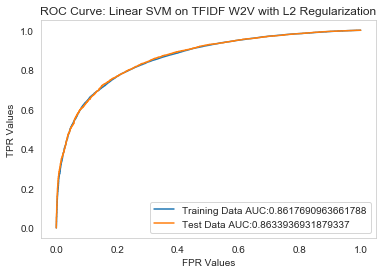

In [148]:
import matplotlib.pyplot as plt

plt.plot(train_fpr8,train_tpr8,label ='Training Data AUC:' + str(auc(train_fpr8,train_tpr8)))
plt.plot(test_fpr8,test_tpr8,label = 'Test Data AUC:' + str(auc(test_fpr8,test_tpr8)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Linear SVM on TFIDF W2V with L2 Regularization')

plt.grid(False)
plt.show()

In [149]:
Y_Train_pred8 = TFIDFW2V_Test_L2.predict_proba(X_LKTrain_SCTFIDFW2V)[:,1]
Y_Test_pred8 = TFIDFW2V_Test_L2.predict_proba(X_LKTest_SCTFIDFW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6135678840434017
Threshold for Maximum Value of tpr*(1-fpr) : 0.654


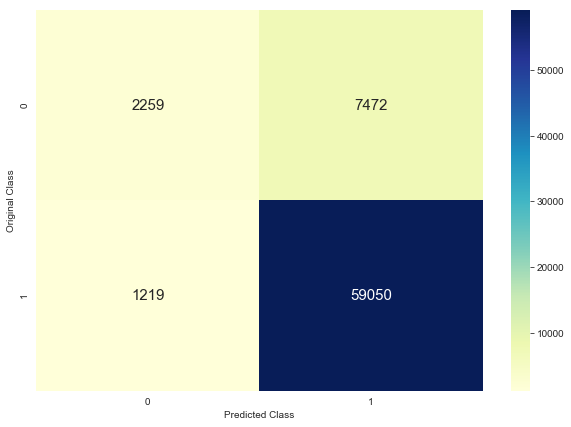

In [150]:
TFIDFW2V_Train2 = confusion_matrix(Y_LKTrain,matrixpredict(Y_Train_pred8,threshold,train_tpr8,train_fpr8))
plottrainmatrix(TFIDFW2V_Train2)

Accuracy on Training Data => (59050+2259)/70000 = 87.58%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6163443142267485
Threshold for Maximum Value of tpr*(1-fpr) : 0.84


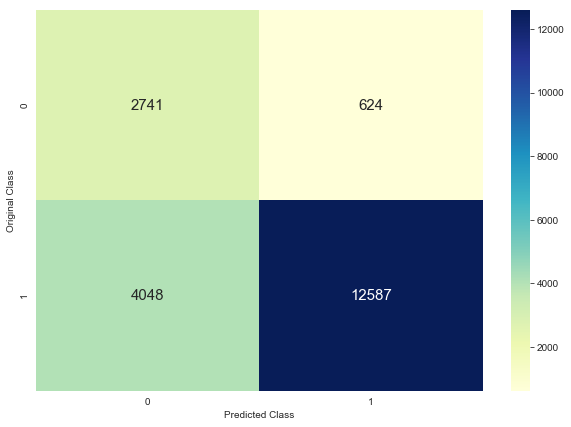

In [151]:
TFIDFW2V_Test2 = confusion_matrix(Y_LKTest,matrixpredict(Y_Test_pred8,threshold,test_tpr8,test_fpr8))
plottestmatrix(TFIDFW2V_Test2)

Accuracy on the Test Data => (12587+2741)/20000 = 76.64%

# [5.2] Applying RBF SVM on Various Feature Sets :-

# Obtaining Train, CV and Test Data:

In [152]:
rbfdf = df[:20000]

Here we are taking a total of 20K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 14,000 
            # of Datapoints in CV data = 2000
            # of Datapoints in Test data = 4000

In [153]:
Tr_rbfdf = rbfdf[:14000]
CV_rbfdf = lineardf[14000:16000]
Te_rbfdf = lineardf[16000:20000]

In [154]:
Tr_rbfdf.shape

(14000, 2)

In [155]:
CV_rbfdf.shape

(2000, 2)

In [156]:
Te_rbfdf.shape

(4000, 2)

Yes everything is working as expected: There are 14K points in the Training data, 2K points in the CV data and 4K
points in the Test data.

Now we can split the data as features in X and the class label in Y.

In [157]:
X_RBFTrain = Tr_rbfdf['Preprocessed_Reviews']
Y_RBFTrain = Tr_rbfdf['Score']

X_RBFCV = CV_rbfdf['Preprocessed_Reviews']
Y_RBFCV = CV_rbfdf['Score']

X_RBFTest = Te_rbfdf['Preprocessed_Reviews']
Y_RBFTest = Te_rbfdf['Score']

'RBF' is used as a prefix in this scenario to denote the RBF Kernel.

In [158]:
Y_RBFTrain.value_counts()

1    12506
0     1494
Name: Score, dtype: int64

In [159]:
Y_RBFCV.value_counts()

1    1770
0     230
Name: Score, dtype: int64

In [160]:
Y_RBFTest.value_counts()

1    3540
0     460
Name: Score, dtype: int64

Still, even with this data split this is a real world imbalanced dataset.

# [5.2.1] SET 1 : Applying RBF SVM on BOW :-

In [161]:
count_vect_rbf = CountVectorizer(min_df=10,max_features=500)
count_vect_rbf.fit(X_RBFTrain) #Again the fit function is applied only on the Train data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical vector.

#We have considered min_df=10 to ensure that all the words with frequency of less than 10 are ignored and 
#max_features=500 ensures that only the Top 500 of the features are considered.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [162]:
X_RBFTrain_BOW = count_vect_rbf.transform(X_RBFTrain)
X_RBFCV_BOW = count_vect_rbf.transform(X_RBFCV)
X_RBFTest_BOW = count_vect_rbf.transform(X_RBFTest)

In [163]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_RBFTrain.shape,Y_RBFTrain.shape)
print(X_RBFCV.shape,Y_RBFCV.shape)
print(X_RBFTest.shape,Y_RBFTest.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_RBFTrain_BOW.shape,Y_RBFTrain.shape)
print(X_RBFCV_BOW.shape,Y_RBFCV.shape)
print(X_RBFTest_BOW.shape,Y_RBFTest.shape)

Shapes before the BOW Vectorization was carried out:
(14000,) (14000,)
(2000,) (2000,)
(4000,) (4000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(14000, 500) (14000,)
(2000, 500) (2000,)
(4000, 500) (4000,)


# Hyperparameter Tuning on the RBF SVM's BOW Representation :- 

In [164]:
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

Scaler5 = StandardScaler(with_mean=False)

X_RBFTrain_SCBOW = Scaler5.fit_transform(X_RBFTrain_BOW)
X_RBFCV_SCBOW = Scaler5.transform(X_RBFCV_BOW)
X_RBFTest_SCBOW = Scaler5.transform(X_RBFTest_BOW)

In [165]:
C_hyperparam = alpha_hyperparam[0:5]

In [166]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

RBFTrain_AUC_BOW=[]
RBFCV_AUC_BOW=[]

for i in tqdm(C_hyperparam):
    RBFSVM_1 = SVC(C=i,kernel='rbf',class_weight='balanced',max_iter=-1)
    RBFSVM_1.fit(X_RBFTrain_SCBOW,Y_RBFTrain)
    BOW_model_RBF = CalibratedClassifierCV(RBFSVM_1,method='sigmoid',cv=10)
    BOW_model_RBF.fit(X_RBFTrain_SCBOW,Y_RBFTrain)
    
    Y_Train_pred9 = BOW_model_RBF.predict_proba(X_RBFTrain_SCBOW)[:,1]
    Y_CV_pred9 = BOW_model_RBF.predict_proba(X_RBFCV_SCBOW)[:,1]
    
    RBFTrain_AUC_BOW.append(roc_auc_score(Y_RBFTrain,Y_Train_pred9))
    RBFCV_AUC_BOW.append(roc_auc_score(Y_RBFCV,Y_CV_pred9))

100%|██████████| 5/5 [53:31<00:00, 614.25s/it]


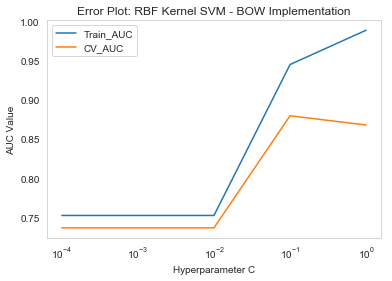

In [167]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFTrain_AUC_BOW,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFCV_AUC_BOW,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')
plt.title('Error Plot: RBF Kernel SVM - BOW Implementation')

plt.grid(False)
plt.show()

Again, From the curves plotted above we choose the Best value of C on the basis of AUC as a metric such that :
* The AUC value on the CV Dataset is the maximum. 
* The gap between the Train and CV AUC Curves is low. 

Therefore based on these 2 conditions, with the help of the curves above, I can choose the best value of C to be 
equal to :

In [169]:
for k in range(0,len(C_hyperparam)):
    print(np.round(RBFCV_AUC_BOW[k],2),"\t", np.round(RBFTrain_AUC_BOW[k] - RBFCV_AUC_BOW[k],3))
optimalC_RBF_BOW = C_hyperparam[3]

0.74 	 0.016
0.74 	 0.016
0.74 	 0.016
0.88 	 0.065
0.87 	 0.121


# Testing with the Test Data for RBF SVM's BOW Representation :-

In [171]:
RBF_SVMTest = SVC(C=optimalC_RBF_BOW,kernel='rbf',class_weight='balanced',max_iter=-1)
RBF_SVMTest.fit(X_RBFTrain_SCBOW,Y_RBFTrain)
BOW_RBFTest = CalibratedClassifierCV(RBF_SVMTest,method='sigmoid',cv=10)
BOW_RBFTest.fit(X_RBFTrain_SCBOW,Y_RBFTrain)

CalibratedClassifierCV(base_estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv=10, method='sigmoid')

In [172]:
from sklearn.metrics import roc_curve, auc 

train_fpr9,train_tpr9,threshold = roc_curve(Y_RBFTrain,BOW_RBFTest.predict_proba(X_RBFTrain_SCBOW)[:,1])
test_fpr9,test_tpr9,threshold = roc_curve(Y_RBFTest,BOW_RBFTest.predict_proba(X_RBFTest_SCBOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

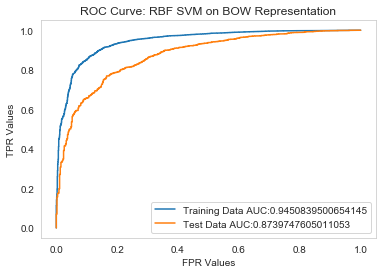

In [173]:
import matplotlib.pyplot as plt

plt.plot(train_fpr9,train_tpr9,label ='Training Data AUC:' + str(auc(train_fpr9,train_tpr9)))
plt.plot(test_fpr9,test_tpr9,label = 'Test Data AUC:' + str(auc(test_fpr9,test_tpr9)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: RBF SVM on BOW Representation')

plt.grid(False)
plt.show()

In [174]:
Y_Train_pred9 = BOW_RBFTest.predict_proba(X_RBFTrain_SCBOW)[:,1]
Y_Test_pred9 = BOW_RBFTest.predict_proba(X_RBFTest_SCBOW)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7729316434135711
Threshold for Maximum Value of tpr*(1-fpr) : 0.686


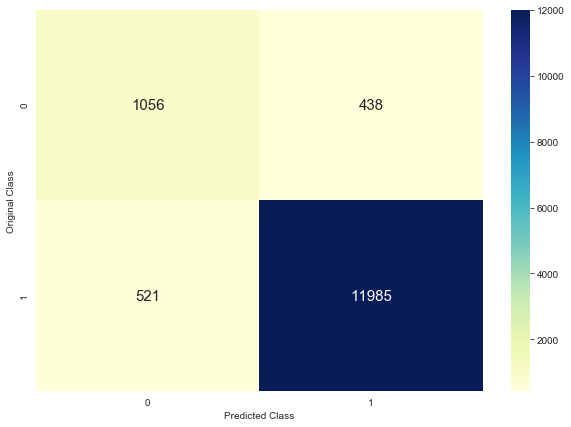

In [186]:
BOW_RBFTrain1 = confusion_matrix(Y_RBFTrain,matrixpredict(Y_Train_pred9,threshold,train_tpr9,train_fpr9))
plottrainmatrix(BOW_RBFTrain1)

Accuracy on Training Data => (11985+1056)/14000 = 93.15%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6418865143699338
Threshold for Maximum Value of tpr*(1-fpr) : 0.913


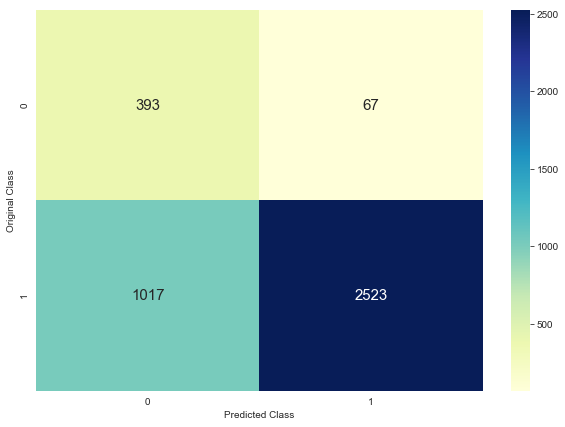

In [187]:
BOW_RBFTest1 = confusion_matrix(Y_RBFTest,matrixpredict(Y_Test_pred9,threshold,test_tpr9,test_fpr9))
plottestmatrix(BOW_RBFTest1)

Accuracy on the Test Data => (2523+393)/4000 = 72.90%

# [5.2.2] SET 2 : Applying RBF SVM on TFIDF :-

In [177]:
tf_idf_vect_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect_rbf.fit(X_RBFTrain)

# Again fit is carried out only on the Training data. fit() internally stores the parameters that will be used to 
#convert the Text to a numerical vector. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [178]:
X_RBFTrain_TFIDF = tf_idf_vect_rbf.transform(X_RBFTrain)
X_RBFCV_TFIDF = tf_idf_vect_rbf.transform(X_RBFCV)
X_RBFTest_TFIDF = tf_idf_vect_rbf.transform(X_RBFTest)

In [179]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_RBFTrain.shape,Y_RBFTrain.shape)
print(X_RBFCV.shape,Y_RBFCV.shape)
print(X_RBFTest.shape,Y_RBFTest.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_RBFTrain_TFIDF.shape,Y_RBFTrain.shape)
print(X_RBFCV_TFIDF.shape,Y_RBFCV.shape)
print(X_RBFTest_TFIDF.shape,Y_RBFTest.shape)

Shapes before the TFIDF Vectorization was carried out:
(14000,) (14000,)
(2000,) (2000,)
(4000,) (4000,)
Shapes after the TFIDF Vectorization was carried out:
(14000, 500) (14000,)
(2000, 500) (2000,)
(4000, 500) (4000,)


# Hyperparameter Tuning on the RBF SVM's TFIDF Representation :- 

In [180]:
warnings.filterwarnings('ignore')

Scaler6 = StandardScaler(with_mean=False)

X_RBFTrain_SCTFIDF = Scaler6.fit_transform(X_RBFTrain_TFIDF)
X_RBFCV_SCTFIDF = Scaler6.transform(X_RBFCV_TFIDF)
X_RBFTest_SCTFIDF = Scaler6.transform(X_RBFTest_TFIDF)

In [181]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

RBFTrain_AUC_TFIDF=[]
RBFCV_AUC_TFIDF=[]

for i in tqdm(C_hyperparam):
    RBFSVM_2 = SVC(C=i,kernel='rbf',class_weight='balanced',max_iter=-1)
    RBFSVM_2.fit(X_RBFTrain_SCTFIDF,Y_RBFTrain)
    TFIDF_model_RBF = CalibratedClassifierCV(RBFSVM_2,method='sigmoid',cv=10)
    TFIDF_model_RBF.fit(X_RBFTrain_SCTFIDF,Y_RBFTrain)
    
    Y_Train_pred10 = TFIDF_model_RBF.predict_proba(X_RBFTrain_SCTFIDF)[:,1]
    Y_CV_pred10 = TFIDF_model_RBF.predict_proba(X_RBFCV_SCTFIDF)[:,1]
    
    RBFTrain_AUC_TFIDF.append(roc_auc_score(Y_RBFTrain,Y_Train_pred10))
    RBFCV_AUC_TFIDF.append(roc_auc_score(Y_RBFCV,Y_CV_pred10))

100%|██████████| 5/5 [51:38<00:00, 588.79s/it]


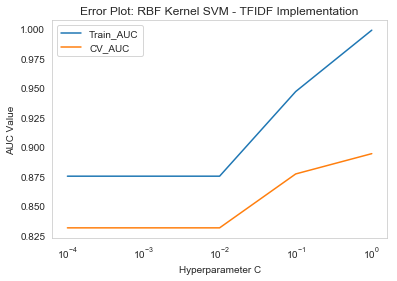

In [182]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFTrain_AUC_TFIDF,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFCV_AUC_TFIDF,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')
plt.title('Error Plot: RBF Kernel SVM - TFIDF Implementation')

plt.grid(False)
plt.show()

In [183]:
for k in range(0,len(C_hyperparam)):
    print(np.round(RBFCV_AUC_TFIDF[k],2),"\t", np.round(RBFTrain_AUC_TFIDF[k] - RBFCV_AUC_TFIDF[k],3))
optimalC_RBF_TFIDF = C_hyperparam[3]

0.83 	 0.044
0.83 	 0.044
0.83 	 0.044
0.88 	 0.07
0.89 	 0.105


# Testing with the Test Data for RBF SVM's TFIDF Representation :-

In [184]:
RBF_SVMTest2 = SVC(C=optimalC_RBF_TFIDF,kernel='rbf',class_weight='balanced',max_iter=-1)
RBF_SVMTest2.fit(X_RBFTrain_SCTFIDF,Y_RBFTrain)
TFIDF_RBFTest = CalibratedClassifierCV(RBF_SVMTest2,method='sigmoid',cv=10)
TFIDF_RBFTest.fit(X_RBFTrain_SCTFIDF,Y_RBFTrain)

CalibratedClassifierCV(base_estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv=10, method='sigmoid')

In [185]:
from sklearn.metrics import roc_curve, auc 

train_fpr10,train_tpr10,threshold = roc_curve(Y_RBFTrain,TFIDF_RBFTest.predict_proba(X_RBFTrain_SCTFIDF)[:,1])
test_fpr10,test_tpr10,threshold = roc_curve(Y_RBFTest,TFIDF_RBFTest.predict_proba(X_RBFTest_SCTFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

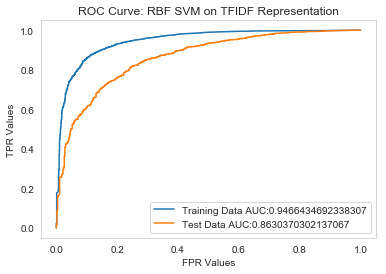

In [188]:
import matplotlib.pyplot as plt

plt.plot(train_fpr10,train_tpr10,label ='Training Data AUC:' + str(auc(train_fpr10,train_tpr10)))
plt.plot(test_fpr10,test_tpr10,label = 'Test Data AUC:' + str(auc(test_fpr10,test_tpr10)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: RBF SVM on TFIDF Representation')

plt.grid(False)
plt.show()

In [189]:
Y_Train_pred10 = TFIDF_RBFTest.predict_proba(X_RBFTrain_SCTFIDF)[:,1]
Y_Test_pred10 = TFIDF_RBFTest.predict_proba(X_RBFTest_SCTFIDF)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7767293921140075
Threshold for Maximum Value of tpr*(1-fpr) : 0.773


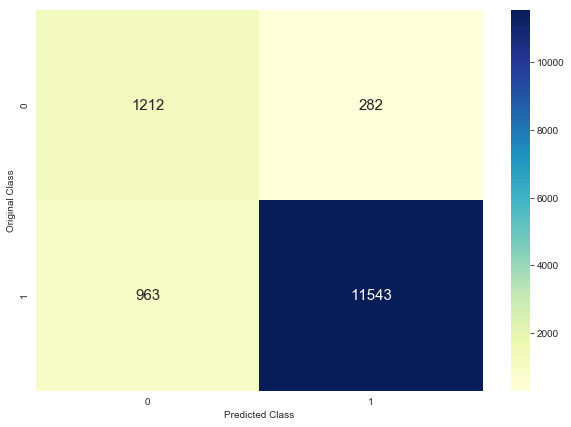

In [190]:
TFIDF_RBFTrain1 = confusion_matrix(Y_RBFTrain,matrixpredict(Y_Train_pred10,threshold,train_tpr10,train_fpr10))
plottrainmatrix(TFIDF_RBFTrain1)

Accuracy on Training Data => (11543+1212)/14000 = 91.10%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6156245394252026
Threshold for Maximum Value of tpr*(1-fpr) : 0.875


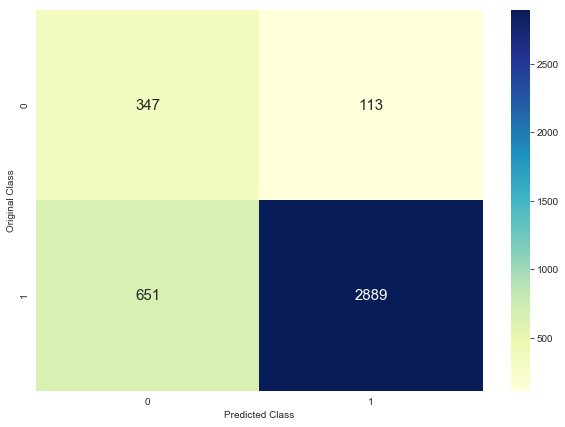

In [191]:
TFIDF_RBFTest1 = confusion_matrix(Y_RBFTest,matrixpredict(Y_Test_pred10,threshold,test_tpr10,test_fpr10))
plottestmatrix(TFIDF_RBFTest1)

Accuracy on the Test Data => (2889+347)/4000 = 80.90%

# [5.2.3] SET 3 : Applying RBF SVM on Avg W2V :-

# Converting Reviews into Numerical Vectors using W2V vectors :-

In [194]:
list_of_sentence_Train_RBF =[]

for sentence in X_RBFTrain:
    list_of_sentence_Train_RBF.append(sentence.split())

In [195]:
w2v_model_RBF =Word2Vec(list_of_sentence_Train_RBF,min_count=10,size=50,max_final_vocab=500,workers=4)

w2v_words_RBF = list(w2v_model_RBF.wv.vocab)
print("Number of words that occur a minimum 10 times :",len(w2v_words_RBF))
print("Some of the sample words are as follows: ", w2v_words_RBF[0:50])

Number of words that occur a minimum 10 times : 497
Some of the sample words are as follows:  ['little', 'makes', 'son', 'along', 'always', 'love', 'new', 'still', 'able', 'years', 'ago', 'bought', 'day', 'something', 'used', 'whole', 'fruit', 'hours', 'many', 'days', 'may', 'not', 'long', 'buying', 'one', 'try', 'really', 'good', 'idea', 'product', 'use', 'made', 'two', 'received', 'could', 'instead', 'easily', 'daughter', 'going', 'lot', 'like', 'recently', 'purchased', 'minutes', 'best', 'ever', 'easy', 'works', 'great', 'also']


# Converting the Train Data Text :- 

In [196]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train_RBF): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF:
            vec = w2v_model_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_RBF.append(sent_vec)
sent_vectors_train_RBF = np.array(sent_vectors_train_RBF)
print(sent_vectors_train_RBF.shape)
print(sent_vectors_train_RBF[0])

100%|██████████| 14000/14000 [00:05<00:00, 2574.63it/s]

(14000, 50)
[ 2.21440006e-02 -2.11117255e-01 -3.24503601e-02  1.97587112e-01
 -5.65960616e-01  1.72513248e-01 -2.55048344e-01  7.05851197e-02
  3.14683586e-01 -2.65475391e-01 -5.37635282e-02  2.38597040e-01
  1.16208810e-01 -1.86540257e-01  2.36107980e-01 -5.96829951e-03
  4.23230761e-01  4.27664308e-01 -1.05898466e-01  2.88753738e-01
 -1.01038606e-01 -1.41615573e-01  6.81537673e-02  2.98907934e-01
 -1.32267126e-01 -3.05427181e-01  5.68333475e-02 -1.97159586e-01
 -2.04531993e-01  1.51093360e-01  1.84429362e-01  3.87852683e-01
  2.37155644e-01 -2.04986783e-01 -3.20101809e-04 -3.50425515e-01
 -3.90853059e-01 -4.26380122e-02 -1.78863425e-01  1.15396336e-01
  2.82328895e-01 -3.00422972e-01 -1.32195634e-01 -4.85762510e-02
  1.62107074e-01  8.76838882e-02 -2.65893850e-02  1.80607072e-01
  2.48119706e-01  2.13829320e-01]


# Converting the CV Data Text :- 

In [197]:
list_of_sentence_CV_RBF=[]

for sentence in X_RBFCV:
    list_of_sentence_CV_RBF.append(sentence.split())

In [198]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV_RBF): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF:
            vec = w2v_model_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv_RBF.append(sent_vec)
sent_vectors_cv_RBF = np.array(sent_vectors_cv_RBF)
print(sent_vectors_cv_RBF.shape)
print(sent_vectors_cv_RBF[0])

100%|██████████| 2000/2000 [00:00<00:00, 2577.23it/s]

(2000, 50)
[ 0.55218393 -0.83634563 -0.2047886   0.65414805 -0.00271277  0.56025875
 -0.49840676 -0.00157974  0.21815383  0.39781355 -0.40075068  0.08664797
 -0.12990039  0.46165919 -0.24034749 -0.34646727 -0.72069921  0.41272112
 -0.54619734 -0.05307118  0.43379523  0.15704481  0.38820192  0.32502424
 -0.41815877 -0.1420002  -1.01032917 -0.18099723  0.81886547  0.39481788
  0.35820274 -0.60356119  0.25967292  0.0014768   0.25675379 -0.17531997
 -0.28702172 -0.03028497 -0.32725213  0.00266647  0.39911991  0.01661866
  1.00979703  0.52475108 -0.35117326 -0.8859166  -0.41588034  0.26815007
  0.18966517 -0.51230477]


# Converting the Test Data Text :- 

In [199]:
list_of_sentence_Test_RBF=[]

for sentence in X_RBFTest:
    list_of_sentence_Test_RBF.append(sentence.split())

In [200]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test_RBF): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF:
            vec = w2v_model_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_RBF.append(sent_vec)
sent_vectors_test_RBF = np.array(sent_vectors_test_RBF)
print(sent_vectors_test_RBF.shape)
print(sent_vectors_test_RBF[0])

100%|██████████| 4000/4000 [00:01<00:00, 2466.68it/s]

(4000, 50)
[ 0.36092013 -0.01104361 -0.05712427  0.10384048 -0.59201595 -0.09675913
 -0.22806705  0.12115272  0.54004873 -0.11746118 -0.43153795  0.02972966
 -0.04194485 -0.20679798  0.25441734  0.21496552  0.38446074  0.47445909
 -0.14618946  0.09456417 -0.0635687   0.30923137 -0.12089878  0.18731606
 -0.13107457 -0.31697013 -0.11353184 -0.48148385  0.0898238  -0.05483306
  0.26173562  0.05427081 -0.21724899 -0.2183513  -0.20035544 -0.16304201
 -0.52694354  0.05660728 -0.15236129  0.08108317  0.61297866 -0.29497341
  0.37672142 -0.32047342  0.24153508 -0.19055467 -0.26549961 -0.02862785
  0.07815288  0.05201562]


In [201]:
print("Shapes before the Avg W2V Vectorization was carried out:")

print(X_RBFTrain.shape,Y_RBFTrain.shape)
print(X_RBFCV.shape,Y_RBFCV.shape)
print(X_RBFTest.shape,Y_RBFTest.shape)

print("="*100)

print("Shapes after the Avg W2V Vectorization was carried out:")

print(sent_vectors_train_RBF.shape,Y_RBFTrain.shape)
print(sent_vectors_cv_RBF.shape,Y_RBFCV.shape)
print(sent_vectors_test_RBF.shape,Y_RBFTest.shape)

Shapes before the Avg W2V Vectorization was carried out:
(14000,) (14000,)
(2000,) (2000,)
(4000,) (4000,)
Shapes after the Avg W2V Vectorization was carried out:
(14000, 50) (14000,)
(2000, 50) (2000,)
(4000, 50) (4000,)


# Hyperparameter Tuning on the RBF SVM's Avg W2V Representation :- 

In [202]:
Scaler7 = StandardScaler(with_mean=False)

X_RBFTrain_SCAW2V = Scaler7.fit_transform(sent_vectors_train_RBF)
X_RBFCV_SCAW2V = Scaler7.transform(sent_vectors_cv_RBF)
X_RBFTest_SCAW2V = Scaler7.transform(sent_vectors_test_RBF)

In [203]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

RBFTrain_AUC_AW2V=[]
RBFCV_AUC_AW2V=[]

for i in tqdm(C_hyperparam):
    RBFSVM_3 = SVC(C=i,kernel='rbf',class_weight='balanced',max_iter=-1)
    RBFSVM_3.fit(X_RBFTrain_SCAW2V,Y_RBFTrain)
    AW2V_model_RBF = CalibratedClassifierCV(RBFSVM_3,method='sigmoid',cv=10)
    AW2V_model_RBF.fit(X_RBFTrain_SCAW2V,Y_RBFTrain)
    
    Y_Train_pred11 = AW2V_model_RBF.predict_proba(X_RBFTrain_SCAW2V)[:,1]
    Y_CV_pred11 = AW2V_model_RBF.predict_proba(X_RBFCV_SCAW2V)[:,1]
    
    RBFTrain_AUC_AW2V.append(roc_auc_score(Y_RBFTrain,Y_Train_pred11))
    RBFCV_AUC_AW2V.append(roc_auc_score(Y_RBFCV,Y_CV_pred11))

100%|██████████| 5/5 [23:27<00:00, 269.34s/it]


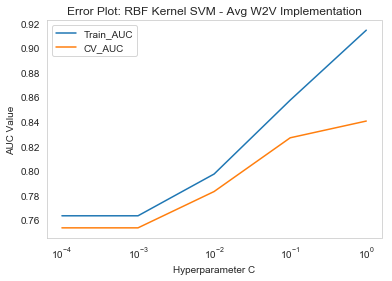

In [204]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFTrain_AUC_AW2V,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFCV_AUC_AW2V,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')
plt.title('Error Plot: RBF Kernel SVM - Avg W2V Implementation')

plt.grid(False)
plt.show()

In [205]:
for k in range(0,len(C_hyperparam)):
    print(np.round(RBFCV_AUC_AW2V[k],2),"\t", np.round(RBFTrain_AUC_AW2V[k] - RBFCV_AUC_AW2V[k],3))
optimalC_RBF_AW2V = C_hyperparam[3]

0.75 	 0.01
0.75 	 0.01
0.78 	 0.014
0.83 	 0.031
0.84 	 0.074


# Testing with the Test Data for RBF SVM's Avg W2V Representation :-

In [206]:
RBF_SVMTest3 = SVC(C=optimalC_RBF_AW2V,kernel='rbf',class_weight='balanced',max_iter=-1)
RBF_SVMTest3.fit(X_RBFTrain_SCAW2V,Y_RBFTrain)
AW2V_RBFTest = CalibratedClassifierCV(RBF_SVMTest3,method='sigmoid',cv=10)
AW2V_RBFTest.fit(X_RBFTrain_SCAW2V,Y_RBFTrain)

CalibratedClassifierCV(base_estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv=10, method='sigmoid')

In [207]:
from sklearn.metrics import roc_curve, auc 

train_fpr11,train_tpr11,threshold = roc_curve(Y_RBFTrain,AW2V_RBFTest.predict_proba(X_RBFTrain_SCAW2V)[:,1])
test_fpr11,test_tpr11,threshold = roc_curve(Y_RBFTest,AW2V_RBFTest.predict_proba(X_RBFTest_SCAW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

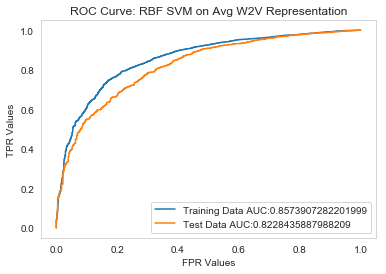

In [208]:
import matplotlib.pyplot as plt

plt.plot(train_fpr11,train_tpr11,label ='Training Data AUC:' + str(auc(train_fpr11,train_tpr11)))
plt.plot(test_fpr11,test_tpr11,label = 'Test Data AUC:' + str(auc(test_fpr11,test_tpr11)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: RBF SVM on Avg W2V Representation')

plt.grid(False)
plt.show()

In [209]:
Y_Train_pred11 = AW2V_RBFTest.predict_proba(X_RBFTrain_SCAW2V)[:,1]
Y_Test_pred11 = AW2V_RBFTest.predict_proba(X_RBFTest_SCAW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6208947416083653
Threshold for Maximum Value of tpr*(1-fpr) : 0.502


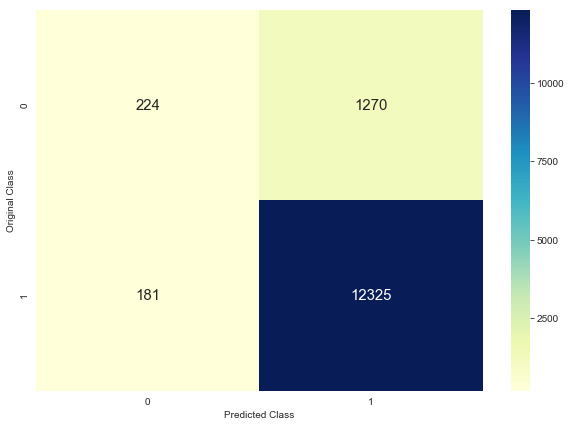

In [210]:
AW2V_RBFTrain1 = confusion_matrix(Y_RBFTrain,matrixpredict(Y_Train_pred11,threshold,train_tpr11,train_fpr11))
plottrainmatrix(AW2V_RBFTrain1)

Accuracy on Training Data => (12325+224)/14000 = 89.63%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5490162122328667
Threshold for Maximum Value of tpr*(1-fpr) : 0.891


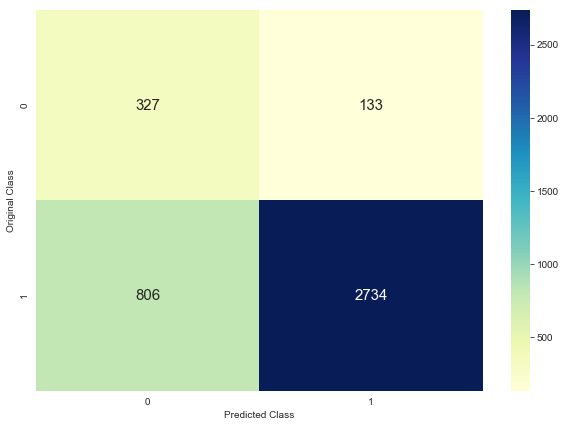

In [211]:
AW2V_RBFTest1 = confusion_matrix(Y_RBFTest,matrixpredict(Y_Test_pred11,threshold,test_tpr11,test_fpr11))
plottestmatrix(AW2V_RBFTest1)

Accuracy on the Test Data => (2734+327)/4000 = 76.52%

# [5.2.4] SET 4 : Applying RBF SVM on TFIDF W2V :-

In [212]:
model_RBF = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_matrix_RBF = model_RBF.fit_transform(X_RBFTrain)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_RBF.get_feature_names(), list(model_RBF.idf_)))

In [213]:
tf_idf_matrix_RBF.shape

(14000, 500)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting the Train Data Text :-

In [215]:
# TF-IDF weighted Word2Vec
tfidf_feat_RBF = model_RBF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RBFtrain = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train_RBF): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF and word in tfidf_feat_RBF:
            vec = w2v_model_RBF.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RBFtrain.append(sent_vec)
    row += 1

100%|██████████| 14000/14000 [00:10<00:00, 1390.35it/s]


# Converting the CV Data Text :-

In [216]:
# TF-IDF weighted Word2Vec
tfidf_feat_RBF = model_RBF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RBFCV = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV_RBF): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF and word in tfidf_feat_RBF:
            vec = w2v_model_RBF.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RBFCV.append(sent_vec)
    row += 1

100%|██████████| 2000/2000 [00:01<00:00, 1299.51it/s]


# Converting the Test Data Text :-

In [217]:
# TF-IDF weighted Word2Vec
tfidf_feat_RBF = model_RBF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RBFtest = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test_RBF): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_RBF and word in tfidf_feat_RBF:
            vec = w2v_model_RBF.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RBFtest.append(sent_vec)
    row += 1

100%|██████████| 4000/4000 [00:02<00:00, 1334.45it/s]


# Hyperparameter Tuning on the RBF SVM's TFIDF W2V Representation :- 

In [218]:
Scaler8 = StandardScaler(with_mean=False)

X_RBFTrain_SCTFIDFW2V = Scaler8.fit_transform(tfidf_sent_vectors_RBFtrain)
X_RBFCV_SCTFIDFW2V = Scaler8.transform(tfidf_sent_vectors_RBFCV)
X_RBFTest_SCTFIDFW2V = Scaler8.transform(tfidf_sent_vectors_RBFtest)

In [219]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

RBFTrain_AUC_TFIDFW2V=[]
RBFCV_AUC_TFIDFW2V=[]

for i in tqdm(C_hyperparam):
    RBFSVM_4 = SVC(C=i,kernel='rbf',class_weight='balanced',max_iter=-1)
    RBFSVM_4.fit(X_RBFTrain_SCTFIDFW2V,Y_RBFTrain)
    TFIDFW2V_model_RBF = CalibratedClassifierCV(RBFSVM_4,method='sigmoid',cv=10)
    TFIDFW2V_model_RBF.fit(X_RBFTrain_SCTFIDFW2V,Y_RBFTrain)
    
    Y_Train_pred12 = TFIDFW2V_model_RBF.predict_proba(X_RBFTrain_SCTFIDFW2V)[:,1]
    Y_CV_pred12 = TFIDFW2V_model_RBF.predict_proba(X_RBFCV_SCTFIDFW2V)[:,1]
    
    RBFTrain_AUC_TFIDFW2V.append(roc_auc_score(Y_RBFTrain,Y_Train_pred12))
    RBFCV_AUC_TFIDFW2V.append(roc_auc_score(Y_RBFCV,Y_CV_pred12))

100%|██████████| 5/5 [24:35<00:00, 283.22s/it]


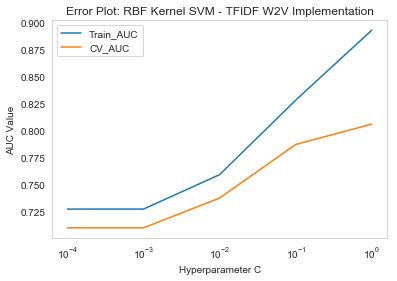

In [220]:
import matplotlib.pyplot as plt 

#Plotting the Training AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFTrain_AUC_TFIDFW2V,label='Train_AUC')

#Plotting the CV AUC for different values of alpha:-
plt.plot(C_hyperparam,RBFCV_AUC_TFIDFW2V,label='CV_AUC')
plt.xscale('log')

plt.legend()

plt.xlabel('Hyperparameter C')
plt.ylabel('AUC Value')
plt.title('Error Plot: RBF Kernel SVM - TFIDF W2V Implementation')

plt.grid(False)
plt.show()

In [221]:
for k in range(0,len(C_hyperparam)):
    print(np.round(RBFCV_AUC_TFIDFW2V[k],2),"\t", np.round(RBFTrain_AUC_TFIDFW2V[k] - RBFCV_AUC_TFIDFW2V[k],3))
optimalC_RBF_TFIDFW2V = C_hyperparam[3]

0.71 	 0.017
0.71 	 0.017
0.74 	 0.022
0.79 	 0.041
0.81 	 0.087


# Testing with the Test Data for RBF SVM's TFIDF W2V Representation :-

In [222]:
RBF_SVMTest4 = SVC(C=optimalC_RBF_TFIDFW2V,kernel='rbf',class_weight='balanced',max_iter=-1)
RBF_SVMTest4.fit(X_RBFTrain_SCTFIDFW2V,Y_RBFTrain)
TFIDFW2V_RBFTest = CalibratedClassifierCV(RBF_SVMTest4,method='sigmoid',cv=10)
TFIDFW2V_RBFTest.fit(X_RBFTrain_SCTFIDFW2V,Y_RBFTrain)

CalibratedClassifierCV(base_estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv=10, method='sigmoid')

In [223]:
from sklearn.metrics import roc_curve, auc 

train_fpr12,train_tpr12,threshold = roc_curve(Y_RBFTrain,TFIDFW2V_RBFTest.predict_proba(X_RBFTrain_SCTFIDFW2V)[:,1])
test_fpr12,test_tpr12,threshold = roc_curve(Y_RBFTest,TFIDFW2V_RBFTest.predict_proba(X_RBFTest_SCTFIDFW2V)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

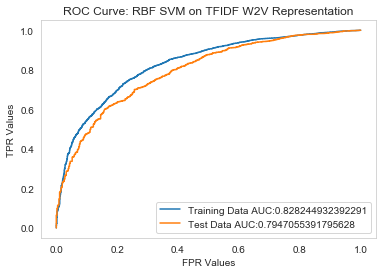

In [224]:
import matplotlib.pyplot as plt

plt.plot(train_fpr12,train_tpr12,label ='Training Data AUC:' + str(auc(train_fpr12,train_tpr12)))
plt.plot(test_fpr12,test_tpr12,label = 'Test Data AUC:' + str(auc(test_fpr12,test_tpr12)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: RBF SVM on TFIDF W2V Representation')

plt.grid(False)
plt.show()

In [225]:
Y_Train_pred12 = TFIDFW2V_RBFTest.predict_proba(X_RBFTrain_SCTFIDFW2V)[:,1]
Y_Test_pred12 = TFIDFW2V_RBFTest.predict_proba(X_RBFTest_SCTFIDFW2V)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5698116309793789
Threshold for Maximum Value of tpr*(1-fpr) : 0.459


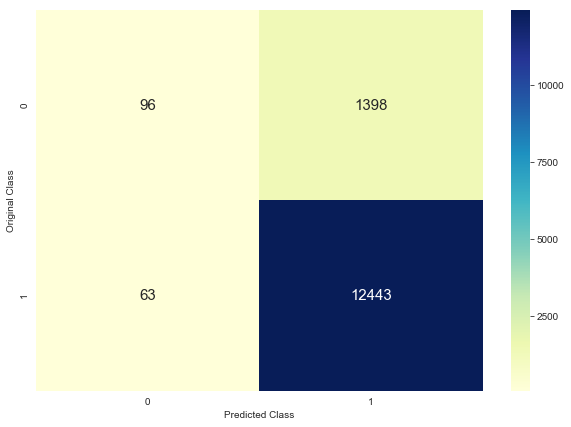

In [226]:
TFIDFW2V_RBFTrain1 = confusion_matrix(Y_RBFTrain,matrixpredict(Y_Train_pred12,threshold,train_tpr12,train_fpr12))
plottrainmatrix(TFIDFW2V_RBFTrain1)

Accuracy on Training Data => (12443+96)/14000 = 89.56%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5204347826086956
Threshold for Maximum Value of tpr*(1-fpr) : 0.907


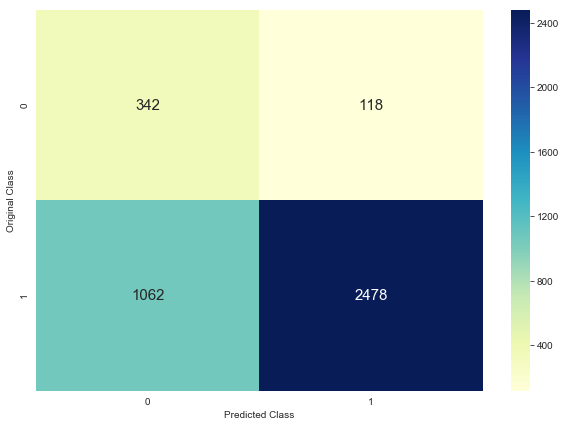

In [227]:
TFIDFW2V_RBFTest1 = confusion_matrix(Y_RBFTest,matrixpredict(Y_Test_pred12,threshold,test_tpr12,test_fpr12))
plottestmatrix(TFIDFW2V_RBFTest1)

Accuracy on the Test Data => (2478+342)/4000 = 70.50%

# [6] Conclusions

In [229]:
from prettytable import PrettyTable

In [232]:
a=PrettyTable()
a.field_names=["S No.","Top 10 Positive Features","Weight(+ve)","Top 10 Negative Features","Weight(-ve)"]

In [233]:
print("Top 10 Positive and Negative Features with Linear SVM & BOW Representation:")
print(" "*100)

a.add_row(["1","great","2774.24","not","-2827.47"])
a.add_row(["2","delicious","2505.49","akg","-1878.73"])
a.add_row(["3","perfect","2202.63","contaminates","-1502.59"])
a.add_row(["4","best","2196.65","senna","-1491.48"])
a.add_row(["5","highly","1869.48","unharmed","-1383.25"])
a.add_row(["6","excellent","1562.36","blotches","-1381.26"])
a.add_row(["7","good","1507.83","crosswise","-1346.14"])
a.add_row(["8","wonderful","1500.01","chuao","-1343.18"])
a.add_row(["9","nice","1361.04","defibrillator","-1343.03"])
a.add_row(["10","easy","1314.57","shekels","-1342.55"])

print(a)

Top 10 Positive and Negative Features with Linear SVM & BOW Representation:
                                                                                                    
+-------+--------------------------+-------------+--------------------------+-------------+
| S No. | Top 10 Positive Features | Weight(+ve) | Top 10 Negative Features | Weight(-ve) |
+-------+--------------------------+-------------+--------------------------+-------------+
|   1   |          great           |   2774.24   |           not            |   -2827.47  |
|   2   |        delicious         |   2505.49   |           akg            |   -1878.73  |
|   3   |         perfect          |   2202.63   |       contaminates       |   -1502.59  |
|   4   |           best           |   2196.65   |          senna           |   -1491.48  |
|   5   |          highly          |   1869.48   |         unharmed         |   -1383.25  |
|   6   |        excellent         |   1562.36   |         blotches         |   -1381.2

In [234]:
b=PrettyTable()
b.field_names=["S No.","Top 10 Positive Features","Weight(+ve)","Top 10 Negative Features","Weight(-ve)"]

In [235]:
print("Top 10 Positive and Negative Features with Linear SVM & TFIDF Representation:")
print(" "*100)

b.add_row(["1","great","321.54","tell really","-956.50"])
b.add_row(["2","delicious","300.30","everyday not","-935.03"])
b.add_row(["3","water process","285.93","using pods","-850.84"])
b.add_row(["4","love","236.00","smaller normal","-849.81"])
b.add_row(["5","best","221.39","used date","-769.12"])
b.add_row(["6","favorite","220.99","strong cinnamon","-766.48"])
b.add_row(["7","definitely","216.60","germinate","-760.18"])
b.add_row(["8","cream rice","213.74","shipping way","-739.68"])
b.add_row(["9","tasty","213.46","intestine","-731.82"])
b.add_row(["10","wonderful","208.50","large variety","-723.86"])

print(b)

Top 10 Positive and Negative Features with Linear SVM & TFIDF Representation:
                                                                                                    
+-------+--------------------------+-------------+--------------------------+-------------+
| S No. | Top 10 Positive Features | Weight(+ve) | Top 10 Negative Features | Weight(-ve) |
+-------+--------------------------+-------------+--------------------------+-------------+
|   1   |          great           |    321.54   |       tell really        |   -956.50   |
|   2   |        delicious         |    300.30   |       everyday not       |   -935.03   |
|   3   |      water process       |    285.93   |        using pods        |   -850.84   |
|   4   |           love           |    236.00   |      smaller normal      |   -849.81   |
|   5   |           best           |    221.39   |        used date         |   -769.12   |
|   6   |         favorite         |    220.99   |     strong cinnamon      |   -766.

In [236]:
c = PrettyTable()
c.field_names=["S No.","Model","Best Value of alpha","Test Accuracy on Ideal Threshold","Test AUC Score"]

In [237]:
print("Performance on Test Data using different Featurizations using Linear SVM:")
print(" "*100)

c.add_row(["1","BOW (L1 Regularization)","10^(-3)","83.75%","0.903"])
c.add_row(["2","BOW (L2 Regularization)","10^(-4)","77.28%","0.854"])
c.add_row(["3","TFIDF (L1 Regularization)","10^(-3)","86.70%","0.945"])
c.add_row(["4","TFIDF (L2 Regularization)","10^(-4)","82.62%","0.905"])
c.add_row(["5","AW2V (L1 Regularization)","10^(-2)","80.55%","0.893"])
c.add_row(["6","AW2V (L2 Regularization)","10^(-4)","79.77%","0.897"])
c.add_row(["7","TFIDF W2V (L1 Regularization)","10^(-4)","76.68%","0.866"])
c.add_row(["8","TFIDF W2V (L2 Regularization)","10^(-4)","76.64%","0.863"])

print(c)

Performance on Test Data using different Featurizations using Linear SVM:
                                                                                                    
+-------+-------------------------------+---------------------+----------------------------------+----------------+
| S No. |             Model             | Best Value of alpha | Test Accuracy on Ideal Threshold | Test AUC Score |
+-------+-------------------------------+---------------------+----------------------------------+----------------+
|   1   |    BOW (L1 Regularization)    |       10^(-3)       |              83.75%              |     0.903      |
|   2   |    BOW (L2 Regularization)    |       10^(-4)       |              77.28%              |     0.854      |
|   3   |   TFIDF (L1 Regularization)   |       10^(-3)       |              86.70%              |     0.945      |
|   4   |   TFIDF (L2 Regularization)   |       10^(-4)       |              82.62%              |     0.905      |
|   5   |    

In [238]:
d = PrettyTable()
d.field_names=["S No.","Model","Best Value of C","Test Accuracy on Ideal Threshold","Test AUC Score"]

In [239]:
print("Performance on Test Data using different Featurizations using RBF Kernel SVM:")
print(" "*100)

d.add_row(["1","BOW","0.1","72.90%","0.874"])
d.add_row(["2","TFIDF","0.1","80.90%","0.863"])
d.add_row(["3","Avg W2V","0.1","76.52%","0.823"])
d.add_row(["4","TFIDF W2V","0.1","70.50%","0.794"])

print(d)

Performance on Test Data using different Featurizations using RBF Kernel SVM:
                                                                                                    
+-------+-----------+-----------------+----------------------------------+----------------+
| S No. |   Model   | Best Value of C | Test Accuracy on Ideal Threshold | Test AUC Score |
+-------+-----------+-----------------+----------------------------------+----------------+
|   1   |    BOW    |       0.1       |              72.90%              |     0.874      |
|   2   |   TFIDF   |       0.1       |              80.90%              |     0.863      |
|   3   |  Avg W2V  |       0.1       |              76.52%              |     0.823      |
|   4   | TFIDF W2V |       0.1       |              70.50%              |     0.794      |
+-------+-----------+-----------------+----------------------------------+----------------+


<b> <font color="black"> Following are some Conclusions from the observations:- </font> </b>

* As far as the Linear SVM performance for the different featurizations is concerned, TFIDF with L1 Regularization is
  the best across all the models since it has the highest Test Accuracy and Test AUC. This is followed by BOW with L1
  Regularization.
* Again, with the RBF Kernel Implementation across the various featurizations, TFIDF is performing the best with a higher Test Accuracy as well as AUC Values as compared to the others.